In [1]:
import sys
from pathlib import Path
sys.path.append(
    str(Path.cwd().parent.resolve())
)

In [2]:
import argparse
import re
import subprocess
from multiprocessing import cpu_count
from typing import List, Set
import operator

import pandas as pd
import numpy as np

from rdkit import RDLogger
from rdkit.Chem import rdChemReactions
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

from openTSNE import TSNE

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from tqdm import tqdm

import src.utils as ut
from src import root
from src.prediction import MTReagentPredictor, MTProductPredictor
from src.preprocessing import HeuristicRoleClassifier, SOLVENTS

In [3]:
from IPython.display import display

In [4]:
tqdm.pandas()

In [5]:
RDLogger.DisableLog('rdApp.*')

In [6]:
def extract_publication_year(info: str):
    possible_year = info.replace("(", ")").split(")")
    for s in possible_year:
        try:
            return int(s)
        except ValueError:
            continue


def remove_redundant_separators(smi: str) -> str:
    """
    Removes trailing or repeated separators from a SMILES string
    :param smi: A SMILES string encoding several molecules
    :return: A SMILES string with no redundant separators
    """
    return ".".join([i for i in smi.split('.') if i != ''])


def standardize_pd_pph3(smi: str) -> str:
    """
    Replaces a Pd(PPh3)4 molecule with 5 separate species - one Pd and four PPh3
    :param smi:
    :return:
    """
    united = "c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1"
    split = "[Pd].c1ccc(P(c2ccccc2)c2ccccc2)cc1.c1ccc(P(c2ccccc2)c2ccccc2)cc1.c1ccc(P(c2ccccc2)c2ccccc2)cc1.c1ccc(P(c2ccccc2)c2ccccc2)cc1"
    return smi.replace(united, split)


def match_accuracy(tgt_and_pred: 'pd.Series', mode: str) -> List[int]:
    """
    Calculates the accuracy of reagent predictions.
    :param tgt_and_pred: The series, where the first row containts the target string,
    and all the other contain predictions ordered by priority.
    The function is meant to be applied to a DataFrame of shape (M, N+1), where M is the number of reactions
    and N is the number of predictions.
    :param mode: If it is 'exact', calculates exact match accuracy.
    If it is 'partial', calculates partial match accuracy.
    :return: List of zeros and ones of length N.
    """

    def _exact_match(t_set: Set[str], p_set: Set[str]) -> bool:
        return len(t_set.symmetric_difference(p_set)) == 0

    def _partial_match(t_set: Set[str], p_set: Set[str]) -> bool:
        return len(t_set & p_set) > 0

    if mode == 'exact':
        _match = _exact_match
    elif mode == 'partial':
        _match = _partial_match
    else:
        raise ValueError(f"The only allowed values for the 'mode' argument are 'exact' and 'partial', not {mode}")

    tgt_mols, *pred_mols = tgt_and_pred
    tgt_set = {s for s in tgt_mols.split(".") if s}
    topn = {i + 1: False for i in range(len(pred_mols))}
    for i, p in enumerate(pred_mols):
        pred_set = {s for s in p.split(".") if s}
        topn[i + 1] = topn.get(i, False) or _match(tgt_set, pred_set)
    return [int(topn[i + 1]) for i in range(len(pred_mols))]


def recall(tgt_and_pred: 'pd.Series') -> List[float]:
    """
    Calculates the recall of reagent predictions.
    :param tgt_and_pred: The series, where the first row containts the target string,
    and all the other contain predictions ordered by priority.
    The function is meant to be applied to a DataFrame of shape (M, N+1), where M is the number of reactions
    and N is the number of predictions.
    :param mode: If it is 'exact', calculates exact match accuracy.
    If it is 'partial', calculates partial match accuracy.
    :return: List of recall scores of length N.
    """

    tgt_mols, *pred_mols = tgt_and_pred
    tgt_set = {s for s in tgt_mols.split(".") if s}
    tgt_set_orig_len = len(tgt_set)
    topn = {i + 1: 0 for i in range(len(pred_mols))}
    for i, p in enumerate(pred_mols):
        pred_set = {s for s in p.split(".") if s}
        tgt_set = tgt_set - pred_set
        topn[i + 1] = 1 - len(tgt_set) / tgt_set_orig_len
    return [topn[i + 1] for i in range(len(pred_mols))]


def plot_confidence_distributions(confs: 'pd.Series', match: 'pd.Series', figsize):
    fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=figsize)

    plt.sca(ax[0])
    sns.violinplot(y=confs,
                   scale="width",
                   ax=plt.gca())
    plt.grid(axis='y')

    plt.sca(ax[1])
    sns.boxplot(x=match, y=confs, ax=plt.gca())
    plt.grid(axis='y')

    return fig, ax

In [7]:
CLASS_COLORS = {
    "Acylation and related processes": "#C0392B",
    "Heteroatom alkylation and arylation": "#E67E22",
    "C-C bond formation": "#27AE60",
    "Heterocycle formation": "#F1C40F",
    "Protections": "#1186F3",
    "Deprotections": "#707B7C",
    "Reductions": "#40C4DE",
    "Oxidations": "#DC40DE",
    "Functional group interconversion (FGI)": "#CCAF1C",
    "Functional group addition (FGA)": "#8E44AD"
}


class ReactionFPS:
    """
    Calculates reaction fingerprints using RDKit.
    """

    FP_TYPES = {"AtomPairFP": rdChemReactions.FingerprintType.AtomPairFP,
                "MorganFP": rdChemReactions.FingerprintType.MorganFP,
                "PatternFP": rdChemReactions.FingerprintType.PatternFP,
                "RDKitFP": rdChemReactions.FingerprintType.RDKitFP,
                "TopologicalTorsion": rdChemReactions.FingerprintType.TopologicalTorsion
                }

    def calculate(self,
                  rx_smi: str,
                  fp_method: str,
                  n_bits: int,
                  fp_type: str,
                  include_agents: bool,
                  agent_weight: int,
                  non_agent_weight: int,
                  bit_ratio_agents: float = 0.2
                  ) -> 'np.array':
        """
        Calculates reaction fingerprints for a given reaction SMILES string.
        More info on arguments: https://www.rdkit.org/docs/cppapi/structRDKit_1_1ReactionFingerprintParams.html
        :param rx_smi: Reaction SMILES to calculate fingerprints for.
        :param fp_method: 'structural' or 'difference'.
        :param n_bits: Number of bits in the fingerprint vectors
        :param fp_type: the algorithm for fingerprints, e.g. AtompairFP.
        Be aware that only AtompairFP, TopologicalTorsion and MorganFP are supported in the difference fingerprint.
        :param include_agents: a flag: include the agents of a reaction for fingerprint generation or not
        :param agent_weight: if agents are included, agents could
        be weighted compared to reactants and products in difference fingerprints.
        :param non_agent_weight: in difference fingerprints weight factor for reactants and products compared to agents
        :param bit_ratio_agents: in structural fingerprints it determines the ratio of bits of the agents in the fingerprint
        :return: fingerprint vector (numpy array)
        """
        # === Parameters section
        params = rdChemReactions.ReactionFingerprintParams()
        params.fpSize = n_bits
        params.includeAgents = include_agents
        params.fpType = self.FP_TYPES[fp_type]
        # ===

        rxn = rdChemReactions.ReactionFromSmarts(
            rx_smi,
            useSmiles=True)

        arr = np.zeros((1,))
        if fp_method == "difference":
            params.agentWeight = agent_weight
            params.nonAgentWeight = non_agent_weight
            # NOTE: difference fingerprints are not binary
            fps = rdChemReactions.CreateDifferenceFingerprintForReaction(rxn, params)

        elif fp_method == "structural":
            params.bitRatioAgents = bit_ratio_agents
            # NOTE: structural fingerprints are binary
            fps = rdChemReactions.CreateStructuralFingerprintForReaction(rxn, params)
        else:
            raise ValueError("Invalid fp_method. Allowed are 'difference' and 'structural'")

        ConvertToNumpyArray(fps, arr)
        return arr


def diff_fp(smi: str) -> 'np.array':
    return ReactionFPS().calculate(smi,
                                   fp_method="difference",
                                   n_bits=2048,
                                   fp_type="MorganFP",
                                   include_agents=True,
                                   agent_weight=1,
                                   non_agent_weight=1)


def plot_2d_distribution(x,
                         y,
                         save_path=None,
                         ax=None,
                         title=None,
                         draw_legend=True,
                         colors=None,
                         legend_kwargs=None,
                         label_order=None,
                         **kwargs) -> None:
    """
    Plots TSNE embeddings
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 20))

    if title is not None:
        ax.set_title(title)

    plot_params = {"alpha": kwargs.get("alpha", 0.6), "s": kwargs.get("s", 1)}

    # Create main plot
    if label_order is not None:
        assert all(np.isin(np.unique(y), label_order))
        classes = [l for l in label_order if l in np.unique(y)]
    else:
        classes = np.unique(y)
    if colors is None:
        default_colors = matplotlib.rcParams["axes.prop_cycle"]
        colors = {k: v["color"] for k, v in zip(classes, default_colors())}

    point_colors = list(map(colors.get, y))

    ax.scatter(x[:, 0], x[:, 1], c=point_colors, rasterized=True, **plot_params)

    # Hide ticks and axis
    ax.set_xticks([]), ax.set_yticks([]), ax.axis("off")

    if draw_legend:
        legend_handles = [
            matplotlib.lines.Line2D(
                [],
                [],
                marker="s",
                color="w",
                markerfacecolor=colors[yi],
                ms=10,
                alpha=1,
                linewidth=0,
                label=yi,
                markeredgecolor="k",
            )
            for yi in classes
        ]
        legend_kwargs_ = dict(loc="best", bbox_to_anchor=(1, 0.5), frameon=False, )
        if legend_kwargs is not None:
            legend_kwargs_.update(legend_kwargs)
        ax.legend(handles=legend_handles, **legend_kwargs_)

    if save_path is not None:
        plt.savefig(save_path, dpi=400, transparent=True)
    else:
        plt.show()


def plot_rxn_class_proportions(classes_in: 'pd.Series',
                               classes_out: 'pd.Series',
                               save_path=None) -> None:
    """
    Plot the graph comparing the proportions of the ten reaction classes from USPTO 50K
    between the in-distribution data and the out-of-distribution data.
    :param save_path: Path to save the image.
    :param classes_in: Proportions of reaction classes for the in-distribution data.
    :param classes_out: Proportions of reaction classes for the out-of-distribution data.
    :return:
    """

    plt.figure(figsize=(15, 8))
    width = 0.3

    plt.bar(
        np.arange(len(classes_in)),
        classes_in,
        width,
        color='#abebc6',
        alpha=1,
        label="USPTO 50K"
    )
    plt.bar(
        np.arange(len(classes_in)) + width,
        classes_out[classes_in.index],
        width,
        color='#cd6155',
        alpha=1,
        label="Reaxys Test"
    )
    plt.legend()
    plt.xticks(np.arange(len(classes_in)) + width / 2,
               [i.split("(")[-1].strip('(').strip(')') for i in classes_in.index],
               rotation=35,
               fontsize=16)
    plt.title("Proportion of reaction classes")
    plt.grid(axis='y')

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()

In [8]:
np.random.seed(123456)

### Arguments

In [9]:
USPTO50_PATH = "../uspto50k.csv"

TEST_PATH = "../data/raw/reaxys_test_full_nice_classes.csv"
VOCAB = "../data/vocabs/reag_no_MIT_src_vocab.json"
MODEL = "../experiments/trained_models/reag_no_MIT_model_step_80000.pt"
RUN_NAME = "reaxys_rgs_80k_test_full_poster"
SRC_COLUMN = "ReactionRgsSource"
GPU = 0

# Loading the test set and USPTO 50K for visual comparison

In [10]:
# Data which is in-distribution to the training set
data_in = pd.read_csv("../uspto50k.csv")

# Test data
data_out = pd.read_csv(TEST_PATH).fillna('')

In [11]:
data_out.shape

(96729, 13)

In [12]:
stat_in = data_in["General class"].value_counts(normalize=True)

stat_out = data_out["General class"].value_counts(normalize=True)

In [13]:
stat_in

Heteroatom alkylation and arylation       0.287267
Acylation and related processes           0.242895
Deprotections                             0.169739
C-C bond formation                        0.115246
Reductions                                0.097194
Functional group interconversion (FGI)    0.038927
Oxidations                                0.017012
Protections                               0.013533
Heterocycle formation                     0.013059
Functional group addition (FGA)           0.005129
Name: General class, dtype: float64

In [14]:
stat_out

Heteroatom alkylation and arylation       0.281053
Acylation and related processes           0.181486
Deprotections                             0.173702
C-C bond formation                        0.119468
Reductions                                0.111042
Protections                               0.045333
Functional group interconversion (FGI)    0.041353
Functional group addition (FGA)           0.024594
Oxidations                                0.021069
Heterocycle formation                     0.000899
Name: General class, dtype: float64

### Comparing reaction class proportions

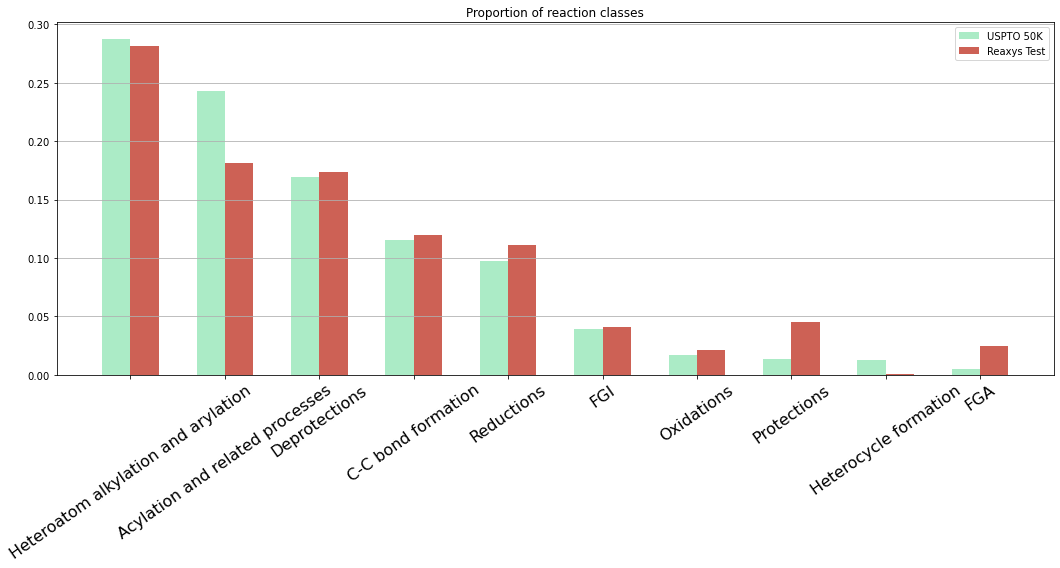

In [15]:
# sns.set_theme(style='white', font_scale=1.5)
plot_rxn_class_proportions(stat_in, stat_out, save_path="proportion.png")

### Comparing the TSNE embeddings of poins in USPTO50K and the test set

In [145]:
tsne = TSNE(
        perplexity=30,
        metric="euclidean",
        n_jobs=cpu_count(),
        random_state=123456,
        verbose=True
    )

In [146]:
fp_in = np.vstack(
        data_in["Reaction"].apply(diff_fp)
    )
embedding_in = tsne.fit(fp_in)

--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
   early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
   initial_momentum=0.5, initialization='pca', ints_in_interval=1,
   learning_rate='auto', max_grad_norm=None, max_step_norm=5,
   metric='euclidean', metric_params=None, min_num_intervals=50,
   n_components=2, n_interpolation_points=3, n_iter=500, n_jobs=12,
   negative_gradient_method='auto', neighbors='auto', perplexity=30,
   random_state=123456, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 63.12 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.64 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 3.31 seconds
===> Running optimization with ex

TSNE is parametric here. It produces embeddings for the test reactions based on the embeddings of reactions in USPTO 50K.

In [147]:
fp_out = np.vstack(
        data_out["FullR"].apply(diff_fp)
    )
embedding_out = embedding_in.transform(fp_out)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 68.31 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.14 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 1488338.2187, 50 iterations in 2.5719 sec
Iteration  100, KL divergence 1484044.5450, 50 iterations in 2.7122 sec
Iteration  150, KL divergence 1481851.2237, 50 iterations in 2.5581 sec
Iteration  200, KL divergence 1480417.9039, 50 iterations in 2.1851 sec
Iteration  250, KL divergence 1479353.3009, 50 iterations in 2.3585 sec
   --> Time elapsed: 12.39 seconds


In [ ]:
plot_2d_distribution(embedding_in,
                     data_in["General class"],
                     colors=CLASS_COLORS,
                     draw_legend=False,
                     save_path="uspto_map.png",
                     s=15, 
                     alpha=0.5)

In [ ]:
plot_2d_distribution(embedding_out,
                     data_out["General class"],
                     save_path="reaxys_map.png",
                     draw_legend=False,
                     s=15,
                     alpha=0.5,
                     colors={i: CLASS_COLORS.get(i, "#00FF00") for i in data_out["General class"].unique()})

In [ ]:
plot_2d_distribution(
        np.vstack((embedding_in, embedding_out)),
        np.array(["USPTO 50K"] * embedding_in.shape[0] + ["Reaxys Test"] * embedding_out.shape[0]),
        s=10,
        alpha=0.4,
        draw_legend=False,
        save_path="reaxys_and_uspto_map.png"
    )

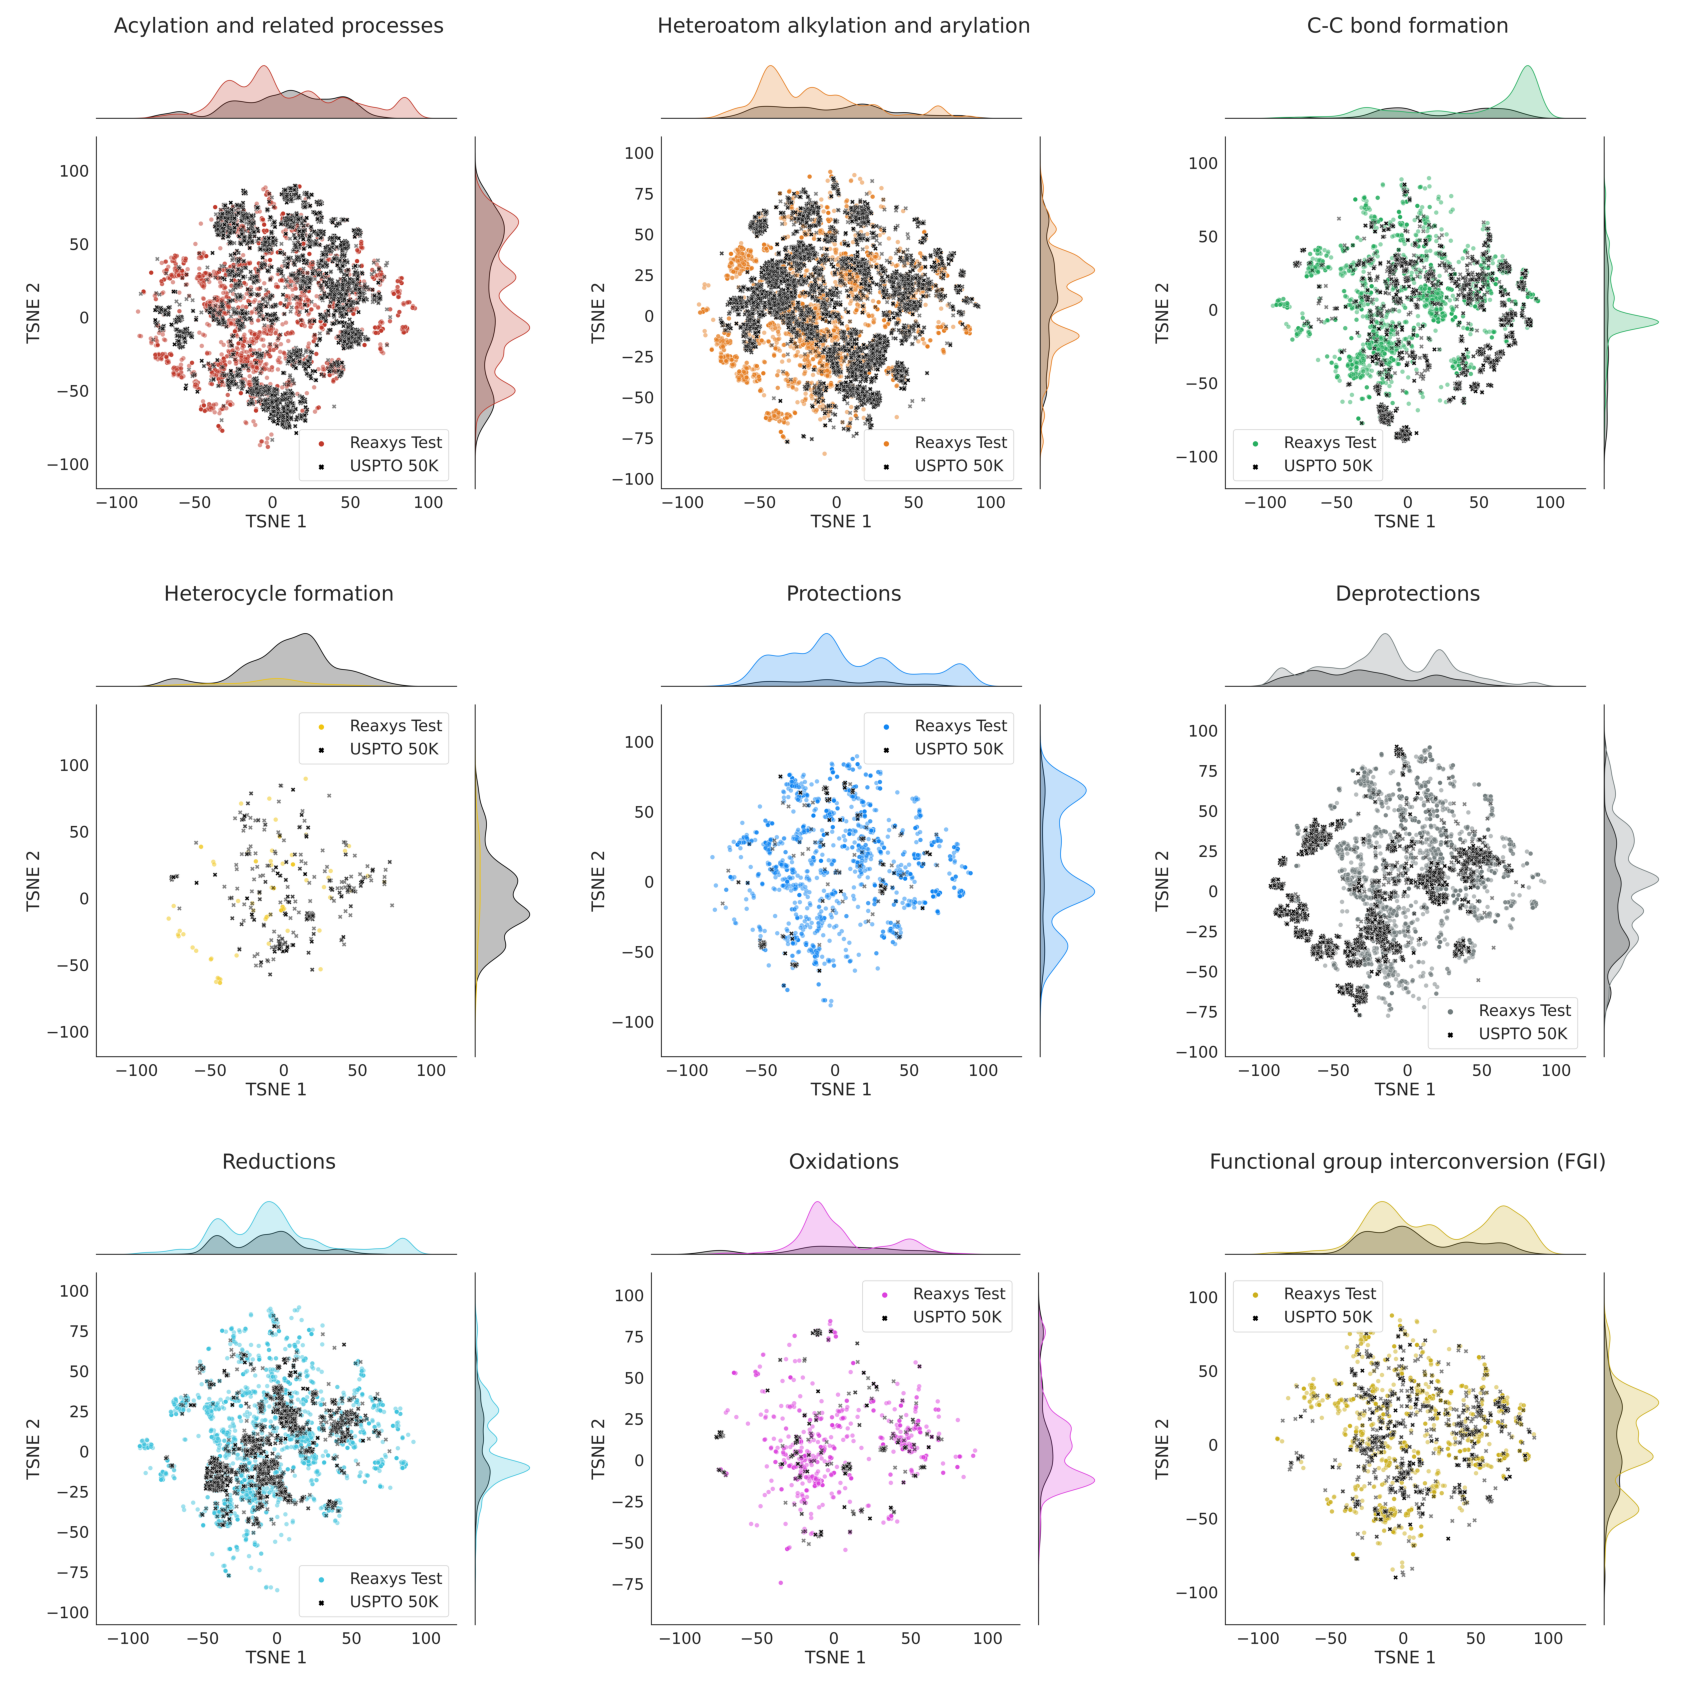

In [321]:
sns.set_theme(style='white', font_scale=1.9)
for j, c in enumerate(CLASS_COLORS):
    if c in data_in["General class"].unique() and c in data_out["General class"].unique():
        _u = embedding_in[data_in["General class"] == c]
        _r = embedding_out[data_out["General class"] == c]
        both = np.vstack((_r, _u))
        h = sns.jointplot(x=both[:, 0],
                          y=both[:, 1],
                          height=10,
                          sizes=[40, 40],
                          kind='scatter',
                          alpha=0.5,
                          palette=[CLASS_COLORS[c], "#000000"],
                          hue=np.array(["Reaxys Test"] * _r.shape[0] + ["USPTO 50K"] * _u.shape[0]),
                          style=np.array(["Reaxys Test"] * _r.shape[0] + ["USPTO 50K"] * _u.shape[0]))
        h.set_axis_labels("TSNE 1", "TSNE 2")
        # plt.suptitle(f"TSNE embeddings of points in USPTO 50K and the test set.\nClass: {c}")
        plt.suptitle(c)
        plt.tight_layout()
        plt.savefig(f"tsne_class_{j}.tiff", dpi=600)
        plt.close()
        
f, axarr = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
for i, a in enumerate(axarr.flatten()):
    a.imshow(mpimg.imread(f'tsne_class_{i}.tiff'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.savefig(f"tsne_all_classes.tiff", dpi=600, transparent=True)
plt.show()

# Loading the test set for reagent prediction

In [15]:
PREDICT = False

In [413]:
test = pd.read_csv(TEST_PATH).fillna('')

In [416]:
test.head()

,Reaction ID,Reaction,Year,Reagent SMILES,Solvent SMILES,Catalyst SMILES,Class,General class,FullR,Reactants,Reagents,Product,ReactionRgsSource,References
0,2825450,OC1CN(CC2=CC=CC=C2)CC1O>>OC1CNCC1O,2008,[H][H],CO,[Pd],6.1.5 N-Bn deprotection [NH deprotections],Deprotections,OC1CN(Cc2ccccc2)CC1O>[H][H].[Pd].CO>OC1CNCC1O,OC1CN(Cc2ccccc2)CC1O,[H][H].[Pd].CO,OC1CNCC1O,OC1CN(Cc2ccccc2)CC1O>>OC1CNCC1O,"Article; Hui, Ailing; Zhang, Jintang; Wang, Zh..."
1,2665200,C(N1CCC2(CC3=CC=CC=C3O2)CC1)C1=CC=CC=C1>>C1C2=...,1981,[H][H],CC(C)O,[Pd],6.1.5 N-Bn deprotection [NH deprotections],Deprotections,c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>[H][H].CC(C)...,c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1,[H][H].CC(C)O.[Pd],c1ccc2c(c1)CC1(CCNCC1)O2,c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>>c1ccc2c(c1)...,"Article; Effland, Richard C.; Gardner, Beth An..."
2,29771268,OC1C2COCC1CN(CC1=CC=CC=C1)C2>>OC1C2CNCC1COC2,2010,[H][H],CCO,[OH-].[OH-].[Pd+2],6.1.5 N-Bn deprotection [NH deprotections],Deprotections,OC1C2COCC1CN(Cc1ccccc1)C2>[Pd+2].[H][H].[OH-]....,OC1C2COCC1CN(Cc1ccccc1)C2,[Pd+2].[H][H].[OH-].[OH-].CCO,OC1C2CNCC1COC2,OC1C2COCC1CN(Cc1ccccc1)C2>>OC1C2CNCC1COC2,Patent; PFIZER INC; WO2010/106457; (2010); A2;
3,3986182,OC1CCN(CC2=CC=CC=C2)C1>>OC1CCNC1,1995,[H][H],CO,[Pd],6.1.5 N-Bn deprotection [NH deprotections],Deprotections,OC1CCN(Cc2ccccc2)C1>[H][H].[Pd].CO>OC1CCNC1,OC1CCN(Cc2ccccc2)C1,[H][H].[Pd].CO,OC1CCNC1,OC1CCN(Cc2ccccc2)C1>>OC1CCNC1,"Article; Horiguchi; Mochida; Bioscience, Biote..."
4,23507222,CC1=CC=C(O)C(CN2C(NC3CCN(CC4=CC=CC=C4)CC3)=NC3...,2008,[H][H],CO,[Pd],6.1.5 N-Bn deprotection [NH deprotections],Deprotections,Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...,Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...,[H][H].[Pd].CO,Cc1ccc(O)c(Cn2c(NC3CCNCC3)nc3ccc(CO)cc32)n1,Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...,"Article; Bonfanti, Jean-François; Meyer, Chris..."


In [108]:
test["Year"] = test["References"].apply(extract_publication_year).fillna(0).astype(int)

In [110]:
test.shape

(96729, 13)

In [111]:
test["General class"].value_counts(normalize=True)

Heteroatom alkylation and arylation       0.281053
Acylation and related processes           0.181486
Deprotections                             0.173702
C-C bond formation                        0.119468
Reductions                                0.111042
Protections                               0.045333
Functional group interconversion (FGI)    0.041353
Functional group addition (FGA)           0.024594
Oxidations                                0.021069
Heterocycle formation                     0.000899
Name: General class, dtype: float64

In [112]:
src_for_rgs = test[SRC_COLUMN]
tgt_for_rgs = test["Reagents"]
print(SRC_COLUMN)

ReactionRgsSource


In [113]:
src_for_rgs

0                          OC1CN(Cc2ccccc2)CC1O>>OC1CNCC1O
1        c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>>c1ccc2c(c1)...
2                OC1C2COCC1CN(Cc1ccccc1)C2>>OC1C2CNCC1COC2
3                            OC1CCN(Cc2ccccc2)C1>>OC1CCNC1
4        Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...
                               ...                        
96724    CS(=O)(=O)N1CC2CC(OCc3ccccc3)CC2C1>>CS(=O)(=O)...
96725    C=C(C)C1CCC2(C(=O)NCCN)CCC3(C)C(CCC4C5(C)CCC(O...
96726    CC(=O)OC1CCC2(C)C(CCC3(C)C2CC=C2C4C(C)C(C)CCC4...
96727    COC12C=CC3(CC1C(C)(O)C(C)(C)C)C1Cc4ccc(OCc5ccc...
96728    CC1(C)CCC2(C(=O)NCCNC(=O)c3ccc(OCc4ccccc4)cc3)...
Name: ReactionRgsSource, Length: 96729, dtype: object

In [114]:
test["Reaction ID"].to_csv("../reaction_ids_reaxys.txt", header=False, index=False)

# Preprocessing Reaxys input for reagents prediction: reassigning roles, sorting

In [115]:
def extract_src(smi: str) -> str:
    left, center, right = smi.split(">")
    return left + ">>" + right


def extract_tgt(smi: str) -> str:
    left, center, right = smi.split(">")
    return center

In [116]:
# Reassigning reactants-reagents
reassigned_fullr = ut.parallelize_on_rows(test["FullR"],
                                          ut.assign_reaction_roles_schneider,
                                          num_of_processes=cpu_count(),
                                          use_tqdm=True)
fullrs = pd.concat((test["FullR"], reassigned_fullr), axis=1)
fullrs.columns = ['before_reass', 'after_reass']
fullrs["after_reass"] = fullrs["after_reass"].apply(lambda x: np.nan if (x.startswith(">") or ">>" in x) else x)
fullrs["after_reass"].fillna(fullrs["before_reass"], inplace=True)
print("Full reaction did not change roles:")
display((fullrs["after_reass"].apply(ut.order_molecules) == fullrs["before_reass"].apply(ut.order_molecules)).value_counts())

src_for_rgs = fullrs["after_reass"].apply(extract_src)
tgt_for_rgs = fullrs["after_reass"].apply(extract_tgt)

 54%|█████▎    | 4317/8061 [01:17<00:55, 67.65it/s] /home/mandronov/anaconda3/envs/reagents_pred/share/RDKit/Contrib/RxnRoleAssignment/identifyReactants.py:396: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if np.array(reacts).shape == (1,0):
100%|██████████| 8061/8061 [02:23<00:00, 56.01it/s] 


Full reaction did not change roles:


True     83681
False    13048
dtype: int64

In [117]:
# Sorting molecules in the source
src_for_rgs = src_for_rgs.apply(ut.order_molecules)

In [118]:
src_for_rgs

0                          OC1CN(Cc2ccccc2)CC1O>>OC1CNCC1O
1        c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>>c1ccc2c(c1)...
2                OC1C2COCC1CN(Cc1ccccc1)C2>>OC1C2CNCC1COC2
3                            OC1CCN(Cc2ccccc2)C1>>OC1CCNC1
4        Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...
                               ...                        
96724    CS(=O)(=O)N1CC2CC(OCc3ccccc3)CC2C1>>CS(=O)(=O)...
96725    C=C(C)C1CCC2(C(=O)NCCN)CCC3(C)C(CCC4C5(C)CCC(O...
96726    CC(=O)OC1CCC2(C)C(CCC3(C)C2CC=C2C4C(C)C(C)CCC4...
96727    COC12C=CC3(CC1C(C)(O)C(C)(C)C)C1Cc4ccc(OCc5ccc...
96728    CC1(C)CCC2(C(=O)NCCNC(=O)c3ccc(OCc4ccccc4)cc3)...
Name: after_reass, Length: 96729, dtype: object

In [119]:
(src_for_rgs == test[SRC_COLUMN]).value_counts()

True     79380
False    17349
dtype: int64

In [120]:
(tgt_for_rgs == '').value_counts()

False    96729
Name: after_reass, dtype: int64

In [121]:
RUN_NAME = "ord_reass_" + RUN_NAME

# Reagent prediction model

The transformer predicts the reagents for a reaction in the form of a SMILES string. We trained our models to predict the reagents for the broad range of reactions without restrictions: the number of reagents and their particular roles are not predetermined. The model yields the output sequentially, token by token, treating the choice of a token as a multiclass classification problem and conditioning that choice on the input sequence and the previously decoded tokens. As we arranged the molecules in the target sequences in the training set by their roles in a reaction, the model is trained to first predict metal catalysts conditioned on the input sequence, if they are necessary, then redox agents conditioning on the input sequence and predicted catalysts, then acids and bases, then uncategorized molecules and ions like alkali metal cations, and finally solvents conditioned on everything mentioned. The solvents are the most interchangeable and they require the most context to predict. A similar reagent role ordering was also used in Gao et al. \cite{Gao2018}.

### Prediction on Reaxys without source ordering and role reassignment

In [29]:
reag_predictor = MTReagentPredictor(
        vocabulary_path=VOCAB,
        model_path=MODEL,
        tokenized_path=str((root / "data" / "test" / ("src_" + RUN_NAME)).with_suffix(".txt")),
        output_path=str((root / "experiments" / "results" / RUN_NAME).with_suffix(".txt")),
        beam_size=5,
        n_best=5,
        batch_size=32,
        gpu=GPU
    )

In [ ]:
%%time
if PREDICT:
    reag_predictor.predict(src_for_rgs)

### Loading predictions

In [30]:
reag_predictor.load_predictions()
pred_rgs = reag_predictor.predictions
pred_rgs_conf = reag_predictor.pred_probs

### Cleaning up predictions a bit

In [31]:
for c in pred_rgs.columns:
    pred_rgs[c] = pred_rgs[c].apply(remove_redundant_separators)
    pred_rgs[c] = pred_rgs[c].apply(ut.IonAssembler.run)
    pred_rgs[c] = pred_rgs[c].apply(standardize_pd_pph3)

### Printing the number of predicted SMILES which are invalid

The model captures the SMILES language structure nicely - ***practically*** all of the predictions of reagent models are valid SMILES strings. 

In [122]:
for c in pred_rgs.columns:
    print(c, (pred_rgs[c] == '').sum())

p_reagents_1 0
p_reagents_2 0
p_reagents_3 0
p_reagents_4 0
p_reagents_5 0


# Calculating accuracy

We analyze the model's performance from several different perspectives:  
  * Perfect match accuracy:   
    The proportion of the predicted SMILES strings in which the molecules exactly match the groung truth molecules.
  * Patial match accuracy:   
    The proportion of the predicted SMILES strings in which at least one of the molecules is in the groung truth set. 
  * Recall: 
    Coverage of the ground truth sequence 

In [123]:
rgs_and_predictions = pd.concat(
        (tgt_for_rgs,
         pred_rgs),
        axis=1
    )
rgs_and_predictions.columns = ["ground_truth"] + list(rgs_and_predictions.columns[1:])
rgs_and_predictions.head()

,ground_truth,p_reagents_1,p_reagents_2,p_reagents_3,p_reagents_4,p_reagents_5
0,CO.[H][H].[Pd],[Pd].CO,[Pd].CCO,[Pd].[H][H].CO,[Pd+2].[OH-].[OH-].CO,[Pd].[H][H].CCO
1,CC(C)O.[H][H].[Pd],[Pd].CCO,[Pd].CO,[Pd].[NH4+].O=C[O-].CO,[Pd+2].[OH-].[OH-].CCO,[Pd+2].[OH-].[OH-].CO
2,CCO.[H][H].[OH-].[OH-].[Pd+2],[Pd].CCO,[Pd].CO,[Pd+2].[OH-].[OH-].CO,[Pd+2].[OH-].[OH-].CCO,[Pd].[H][H].CO
3,CO.[H][H].[Pd],[Pd].CCO,[Pd].CO,[Pd].[H][H].CO,[Pd+2].[OH-].[OH-].CO,[Pd].[H][H].CCO
4,CO.[H][H].[Pd],[Pd].[NH4+].O=C[O-].CO,[Pd+2].[OH-].[OH-].CO,[Pd].CCO,[Pd+2].[OH-].[OH-].CCO,[Pd].[H][H].CO


### Exact match accuracy

In [34]:
topn_exact_match_acc = rgs_and_predictions.apply(
        lambda x: match_accuracy(x, 'exact'),
        axis=1
    )
topn_exact_match_acc = pd.DataFrame(topn_exact_match_acc.to_list())
topn_exact_match_acc.columns = [f"top_{i + 1}_exact" for i in range(pred_rgs.shape[1])]

print("Top-N exact match accuracy")
for c in topn_exact_match_acc.columns:
    print(c, topn_exact_match_acc[c].mean())

Top-N exact match accuracy
top_1_exact 0.15312884450371658
top_2_exact 0.22585780893010368
top_3_exact 0.2690816611357504
top_4_exact 0.29401730608194027
top_5_exact 0.3104859969605806


### Partial match accuracy

In [35]:
topn_partial_match_acc = rgs_and_predictions.apply(
        lambda x: match_accuracy(x, 'partial'),
        axis=1
    )
topn_partial_match_acc = pd.DataFrame(topn_partial_match_acc.to_list())
topn_partial_match_acc.columns = [f"top_{i + 1}_partial" for i in range(pred_rgs.shape[1])]

print("Top-N partial match accuracy")
for c in topn_partial_match_acc.columns:
    print(c, topn_partial_match_acc[c].mean())

Top-N partial match accuracy
top_1_partial 0.6968644356914679
top_2_partial 0.7940534896463315
top_3_partial 0.8398101913593649
top_4_partial 0.8648595560793557
top_5_partial 0.8806769427989538


### Recall

In [36]:
topn_recall = rgs_and_predictions.apply(
        lambda x: recall(x),
        axis=1
    )
topn_recall = pd.DataFrame(topn_recall.to_list())
topn_recall.columns = [f"top_{i + 1}_recall" for i in range(pred_rgs.shape[1])]

In [37]:
topn_recall

,top_1_recall,top_2_recall,top_3_recall,top_4_recall,top_5_recall
0,0.666667,0.666667,1.000000,1.000000,1.000000
1,0.333333,0.333333,0.333333,0.333333,0.333333
2,0.250000,0.250000,0.750000,0.750000,1.000000
3,0.333333,0.666667,1.000000,1.000000,1.000000
4,0.666667,0.666667,0.666667,0.666667,1.000000
...,...,...,...,...,...
96724,0.000000,0.200000,0.400000,0.800000,0.800000
96725,0.666667,0.666667,0.666667,0.666667,0.666667
96726,0.666667,0.666667,0.666667,0.666667,1.000000
96727,0.250000,0.250000,0.250000,0.500000,0.500000


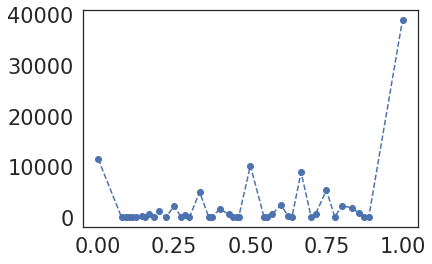

In [180]:
plt.plot(
    topn_recall["top_5_recall"].value_counts().sort_index(),
    '--o',
);

In [38]:
for c in topn_recall.columns:
    print(c, (topn_recall[c] == 1).mean())

top_1_recall 0.1747356015259126
top_2_recall 0.2625789577065823
top_3_recall 0.3267789390978921
top_4_recall 0.3687311974692181
top_5_recall 0.4029401730608194


### Temporal validation

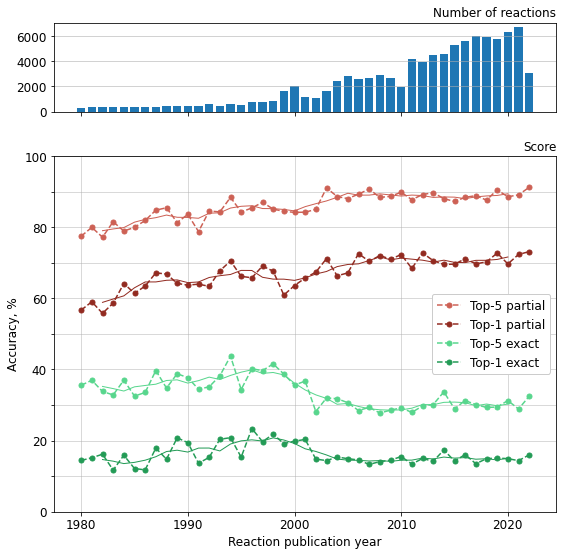

In [969]:
# plt.figure(figsize=(8, 8))
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(9, 9), sharex=True, gridspec_kw={'height_ratios': [1, 4]})

colors_exact = {"1": "#239b56", "5": "#58d68d"}
colors_partial = {"1": "#922b21", "5": "#cd6155"}
fontsize=12
over_years = 5

plt.sca(ax[0])
plt.bar(
    range(1980, 2023),
    test["Year"].value_counts().sort_index().iloc[6:]
)
plt.grid(axis='y', alpha=0.7)
plt.yticks(fontsize=fontsize)
plt.title("Number of reactions", fontsize=fontsize, loc='right')

plt.sca(ax[1])

topn_partial_match_acc_by_year = pd.concat((test["Year"], topn_partial_match_acc), axis=1)

for c in topn_partial_match_acc.columns[::4][::-1]:
    n = c.split("_")[1]
    scores = topn_partial_match_acc_by_year.groupby(by="Year")[c].mean()[6:] # since 1980 
    plt.plot(
        range(1980, 2023),
        scores,
        '--o', 
        alpha=1,
        markersize=5,
        c=colors_partial[n],
        label=f'Top-{n} partial')
    plt.plot(
        range(1980, 2023),
        scores.rolling(over_years, center=True).mean(),
        '-', 
        alpha=1,
        linewidth=1,
        c=colors_partial[n])

topn_exact_match_acc_by_year = pd.concat((test["Year"], topn_exact_match_acc), axis=1)

for c in topn_exact_match_acc.columns[::4][::-1]:
    n = c.split("_")[1]
    scores = topn_exact_match_acc_by_year.groupby(by="Year")[c].mean()[6:] # since 1980 
    plt.plot(
        scores,
        '--o', 
        markersize=5,
        alpha=1,
        c=colors_exact[n],
        label=f'Top-{n} exact')
    plt.plot(
        scores.rolling(over_years, center=True).mean(),
        '-', 
        linewidth=1,
        alpha=1,
        c=colors_exact[n])
# ax[0].legend()
# ax[0].grid()

plt.xticks(fontsize=fontsize)
plt.yticks(np.arange(0, 1.1, 0.1), 
               [int(100 * round(i, 1)) if (round(i, 1) * 10) % 2 == 0 else '' for i in np.arange(0.0, 1.1, 0.1)], 
               fontsize=fontsize)
plt.ylabel("Accuracy, %", fontsize=fontsize)
plt.xlabel("Reaction publication year", fontsize=fontsize)
plt.title("Score", fontsize=fontsize, loc='right')
plt.legend(framealpha=1, fontsize=fontsize)
plt.grid(alpha=0.6)

# plt.savefig("temporal.pdf", dpi=600)
plt.show()

<AxesSubplot:>

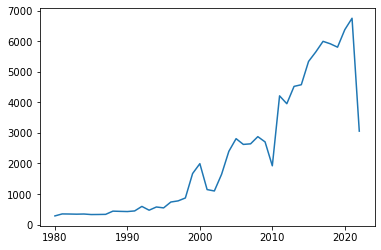

In [946]:
topn_partial_match_acc_by_year["Year"].value_counts().sort_index().iloc[6:].plot()

In [972]:
test["General class"].value_counts()

Heteroatom alkylation and arylation       27186
Acylation and related processes           17555
Deprotections                             16802
C-C bond formation                        11556
Reductions                                10741
Protections                                4385
Functional group interconversion (FGI)     4000
Functional group addition (FGA)            2379
Oxidations                                 2038
Heterocycle formation                        87
Name: General class, dtype: int64

### Accuracy without solvents

In [182]:
rgs_and_predictions

,ground_truth,p_reagents_1,p_reagents_2,p_reagents_3,p_reagents_4,p_reagents_5
0,CO.[H][H].[Pd],[Pd].CO,[Pd].CCO,[Pd].[H][H].CO,[Pd+2].[OH-].[OH-].CO,[Pd].[H][H].CCO
1,CC(C)O.[H][H].[Pd],[Pd].CCO,[Pd].CO,[Pd].[NH4+].O=C[O-].CO,[Pd+2].[OH-].[OH-].CCO,[Pd+2].[OH-].[OH-].CO
2,CCO.[H][H].[OH-].[OH-].[Pd+2],[Pd].CCO,[Pd].CO,[Pd+2].[OH-].[OH-].CO,[Pd+2].[OH-].[OH-].CCO,[Pd].[H][H].CO
3,CO.[H][H].[Pd],[Pd].CCO,[Pd].CO,[Pd].[H][H].CO,[Pd+2].[OH-].[OH-].CO,[Pd].[H][H].CCO
4,CO.[H][H].[Pd],[Pd].[NH4+].O=C[O-].CO,[Pd+2].[OH-].[OH-].CO,[Pd].CCO,[Pd+2].[OH-].[OH-].CCO,[Pd].[H][H].CO
...,...,...,...,...,...,...
96724,CC(=O)O.CO.[H][H].[OH-].[OH-].[Pd+2],[Pd].CCO,[Pd].CO,[Pd].[H][H].CO,[Pd+2].[OH-].[OH-].CO,[Pd].[H][H].CCO
96725,CO.[K+].[OH-],[OH-].[Na+].CO,[OH-].[Na+].CCO,[OH-].[Na+].O.CO,[OH-].[Na+].O.CCO,[OH-].[Li+].O.O.CO
96726,CO.[K+].[OH-],[OH-].[Na+].CO,[OH-].[Na+].CCO,[OH-].[Na+].O.CO,[OH-].[Na+].O.CCO,O=C([O-])[O-].[K+].[K+]
96727,CC(C)O.O.[H][H].[Pd],[Pd].CCO,[Pd].CO,[Pd],[Pd].[H][H].CCO,[Pd].[H][H].CO


In [183]:
def remove_solvents(smi: str) -> str:
    """
    Removes standard solvents from a sequence of molecules separated by dots 
    """
    return '.'.join([i for i in smi.split('.') if i not in SOLVENTS])

In [184]:
rgs_and_predictions_no_solvents = pd.DataFrame()
for c in rgs_and_predictions.columns:
    rgs_and_predictions_no_solvents[c] = rgs_and_predictions[c].apply(remove_solvents)

In [185]:
rgs_and_predictions_no_solvents.head()

,ground_truth,p_reagents_1,p_reagents_2,p_reagents_3,p_reagents_4,p_reagents_5
0,[H][H].[Pd],[Pd],[Pd],[Pd].[H][H],[Pd+2].[OH-].[OH-],[Pd].[H][H]
1,[H][H].[Pd],[Pd],[Pd],[Pd].[NH4+].O=C[O-],[Pd+2].[OH-].[OH-],[Pd+2].[OH-].[OH-]
2,[H][H].[OH-].[OH-].[Pd+2],[Pd],[Pd],[Pd+2].[OH-].[OH-],[Pd+2].[OH-].[OH-],[Pd].[H][H]
3,[H][H].[Pd],[Pd],[Pd],[Pd].[H][H],[Pd+2].[OH-].[OH-],[Pd].[H][H]
4,[H][H].[Pd],[Pd].[NH4+].O=C[O-],[Pd+2].[OH-].[OH-],[Pd],[Pd+2].[OH-].[OH-],[Pd].[H][H]


In [186]:
topn_exact_match_acc_no_solvents = rgs_and_predictions_no_solvents.apply(
        lambda x: match_accuracy(x, 'exact'),
        axis=1
    )
topn_exact_match_acc_no_solvents = pd.DataFrame(topn_exact_match_acc_no_solvents.to_list())
topn_exact_match_acc_no_solvents.columns = [f"top_{i + 1}_exact" for i in range(pred_rgs.shape[1])]

In [187]:
print("Top-N exact match accuracy")
for c in topn_exact_match_acc_no_solvents.columns:
    print(c, topn_exact_match_acc_no_solvents[c].mean())

Top-N exact match accuracy
top_1_exact 0.3118919868912115
top_2_exact 0.3802065564618677
top_3_exact 0.4298400686453907
top_4_exact 0.46037899699159507
top_5_exact 0.48321599520309316


In [188]:
topn_partial_match_acc_no_solvents = rgs_and_predictions_no_solvents.apply(
        lambda x: match_accuracy(x, 'partial'),
        axis=1
    )
topn_partial_match_acc_no_solvents = pd.DataFrame(topn_partial_match_acc_no_solvents.to_list())
topn_partial_match_acc_no_solvents.columns = [f"top_{i + 1}_partial" for i in range(pred_rgs.shape[1])]
print("Top-N partial match accuracy")
for c in topn_partial_match_acc_no_solvents.columns:
    print(c, topn_partial_match_acc_no_solvents[c].mean())

Top-N partial match accuracy
top_1_partial 0.5640397398918628
top_2_partial 0.6464658995751016
top_3_partial 0.6912818286139627
top_4_partial 0.717209937040598
top_5_partial 0.7366766946830837


# How many unique reactions have at least one reagent set predicted right?

In [148]:
# Number of unique reactions in the test set
src_for_rgs.nunique()

86167

In [149]:
# How many duplicates does every unique reaction have
src_for_rgs.value_counts().value_counts().sort_index()

1     76153
2      9673
3       207
4        98
5        16
6        13
7         3
9         2
10        2
Name: after_reass, dtype: int64

In [821]:
unique_rxn_perf = pd.concat(
    (
        src_for_rgs,
        topn_exact_match_acc,
        topn_partial_match_acc,
        (topn_recall == 1).astype(int),
        test["General class"]
    ), 
    axis=1
)
unique_rxn_perf.columns = ["src"] + list(unique_rxn_perf.columns[1:])
unique_rxn_perf = unique_rxn_perf.groupby(by="src")

In [822]:
unique_exact_matches = [unique_rxn_perf[c].max() for c in topn_exact_match_acc.columns]
unique_partial_matches = [unique_rxn_perf[c].max() for c in topn_partial_match_acc.columns]
unique_recalls = [unique_rxn_perf[c].max() for c in topn_recall.columns]
unique_rxn_types = [unique_rxn_perf["General class"].apply(lambda x: x.iloc[0])]
unique_rxn_perf = pd.concat(
    unique_exact_matches + unique_partial_matches + unique_recalls + unique_rxn_types,
    axis=1
).reset_index()

In [823]:
for c in topn_exact_match_acc.columns:
    print(c, round(100 * unique_rxn_perf[c].mean(), 4))
print()  
for c in topn_partial_match_acc.columns:
    print(c, round(100 * unique_rxn_perf[c].mean(), 4))
print()
for c in topn_recall.columns:
    print(c, round(100 * unique_rxn_perf[c].mean(), 4))

top_1_exact 17.0007
top_2_exact 24.6986
top_3_exact 29.2258
top_4_exact 31.7964
top_5_exact 33.4815

top_1_partial 70.8798
top_2_partial 80.4531
top_3_partial 84.8944
top_4_partial 87.3385
top_5_partial 88.8635

top_1_recall 19.1988
top_2_recall 28.403
top_3_recall 35.054
top_4_recall 39.29
top_5_recall 42.7844


# Confidence of predictions

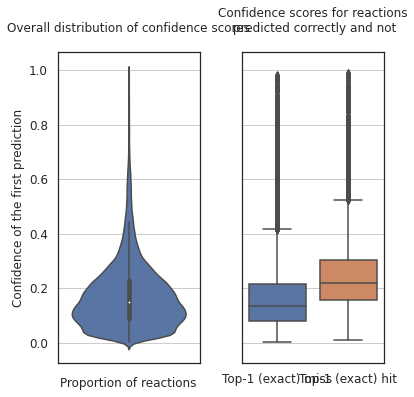

In [320]:
fig, ax = plot_confidence_distributions(
    pred_rgs_conf["p_reagents_1_conf"],
    topn_exact_match_acc["top_1_exact"],
    figsize=(6, 6)
)
fontsize = 12

# fig.suptitle("Distribution of the confidence scores of the model")
ax[0].set_title("Overall distribution of confidence scores", fontsize=fontsize, pad=20)
ax[0].set_xlabel("Proportion of reactions", fontsize=fontsize)
ax[0].set_ylabel("Confidence of the first prediction", fontsize=fontsize)
plt.sca(ax[0])
plt.yticks(fontsize=fontsize)

ax[1].set_title("Confidence scores for reactions\n predicted correctly and not", fontsize=fontsize, pad=20)
ax[1].set_ylabel(None)
plt.sca(ax[1])
plt.xticks(ticks=range(2), labels=["Top-1 (exact) miss", "Top-1 (exact) hit"], fontsize=fontsize)
plt.xlabel(None)

plt.tight_layout()
plt.subplots_adjust()
plt.savefig("confidence.tiff", dpi=600, transparent=True)
plt.show()

# Performance across reaction classes

In [251]:
def plot_performance_across_classes(classes_col: 'pd.Series',
                                    exact_accuracies: 'pd.DataFrame',
                                    partial_accuracies: 'pd.DataFrame',
                                    width: float = 0.2,
                                    **kwargs):
    """
    Plots the performance of reagent prediction across reaction classes.
    :param classes_col: The column with a reaction class name for each reaction
    :param exact_accuracies: The dataframe with exact match accuracies.
    Columns are thought to be ordered by priority in descending order.
    :param partial_accuracies: The dataframe with partial match accuracies.
    Columns are thought to be ordered by priority in descending order.
    :param width: The width of bars to plot
    :return:
    """
    fontsize = kwargs.get("fontsize", 16)
    # fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=kwargs.get("figsize", (8, 8)))
    fig = plt.figure(figsize=kwargs.get('figsize', (14, 5)))
    ax = plt.gca()
    
    colors_exact = {1: "#239b56", 3: "#58d68d", 5: "#abebc6"}
    colors_partial = {1: "#922b21", 3: "#cd6155", 5: "#e6b0aa"}

    ascending_top_1_order = classes_col.value_counts().index
    _accs_classes = pd.concat((classes_col, exact_accuracies, partial_accuracies), axis=1)
    class_col = _accs_classes.columns[0]
    for i in (5, 3, 1):
        score_col = exact_accuracies.columns[i - 1]
        ax.bar(
            np.arange(len(ascending_top_1_order) + 1),
            [0] + list(_accs_classes.groupby(by=[class_col])[score_col].mean()[ascending_top_1_order]),
            width,
            color=colors_exact[i],
            alpha=1,
            linewidth=0,
            edgecolor='none',
            label=f"Top-{i} exact"
        )
        score_col = partial_accuracies.columns[i - 1]
        ax.bar(
            np.arange(len(ascending_top_1_order) + 1) + width,
            [0] + list(_accs_classes.groupby(by=[class_col])[score_col].mean()[ascending_top_1_order]),
            width,
            color=colors_partial[i],
            alpha=1,
            linewidth=0,
            edgecolor='none',
            label=f"Top-{i} partial"
        )

    ax.tick_params(length=0)
    plt.sca(ax)
    plt.grid(axis='y', alpha=0.3)
    plt.title(
        "Reagent prediction scores across reaction classes in the Reaxys test set",
        fontsize=int(fontsize * 0.9),
        loc='right',
        pad=20)

    classes_decreasing = _accs_classes[class_col].value_counts(normalize=True)[ascending_top_1_order]
    ax.bar(
        np.arange(len(ascending_top_1_order) + 1) - width,
        [0] + list(classes_decreasing),
        width,
        # bottom=1.3-classes_decreasing,
        color='k', #[CLASS_COLORS.get(i, "#00FF00") for i in classes_decreasing.index],
        alpha=0.9,
        linewidth=1,
        edgecolor='none',
        label='Class proportion'
    )

    # ax.set_yticks()
    plt.sca(ax)
    plt.yticks(np.arange(-0.1, 1.2, 0.1), 
               [''] + [int(100 * round(i, 1)) if (round(i, 1) * 10) % 2 == 0 else '' for i in np.arange(0.0, 1.1, 0.1)] + 1*[''], 
               fontsize=int(fontsize * 0.7))
    plt.ylabel("Percentage", fontsize=int(fontsize * 0.7))
    plt.xticks(range(11), 
               [''] + ['Heteroatom\nalkylation\nand arylation', 
                'Acylation\nand related\nprocesses',
                'Deprotections',
                '  Reductions',
                'C-C bond\nformation',
                'FGI',
                'Protections',
                'FGA',
                'Oxidations',
                'Heterocycle\nformation'
               ], 
               fontsize=int(fontsize * 0.7))
    plt.legend(loc='upper left', fontsize=int(fontsize * 0.7))

#     ax[1].tick_params(length=0)
    # plt.sca(ax[1])
    # plt.xticks(np.arange(len(ascending_top_1_order)) + width / 2, ascending_top_1_order, rotation=19, fontsize=int(fontsize * 0.8))
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
#     plt.yticks(fontsize=int(fontsize * 0.8))

#     # plt.xticks(rotation=15)
#     plt.xlabel(None)
    
#     plt.grid(axis='y', alpha=0.5)
#     plt.title("Distribution of reaction classes in the test", fontsize=fontsize, loc="right", pad=20)

    # fig.suptitle(
    #     f"Performance of the transformer model on the test set.\nTest size: {test.shape[0]} reactions.",
    #     fontsize=fontsize)

In [197]:
colors={i: CLASS_COLORS.get(i, "#00FF00") for i in data_out["General class"].unique()}

In [198]:
{i: CLASS_COLORS.get(i, "#00FF00") for i in test["General class"].unique()}

{'Deprotections': '#707B7C',
 'Functional group interconversion (FGI)': '#CCAF1C',
 'Acylation and related processes': '#C0392B',
 'Heteroatom alkylation and arylation': '#E67E22',
 'Protections': '#1186F3',
 'Heterocycle formation': '#F1C40F',
 'Functional group addition (FGA)': '#8E44AD',
 'C-C bond formation': '#27AE60',
 'Oxidations': '#DC40DE',
 'Reductions': '#40C4DE'}

In [199]:
CLASS_COLORS

{'Acylation and related processes': '#C0392B',
 'Heteroatom alkylation and arylation': '#E67E22',
 'C-C bond formation': '#27AE60',
 'Heterocycle formation': '#F1C40F',
 'Protections': '#1186F3',
 'Deprotections': '#707B7C',
 'Reductions': '#40C4DE',
 'Oxidations': '#DC40DE',
 'Functional group interconversion (FGI)': '#CCAF1C',
 'Functional group addition (FGA)': '#8E44AD'}

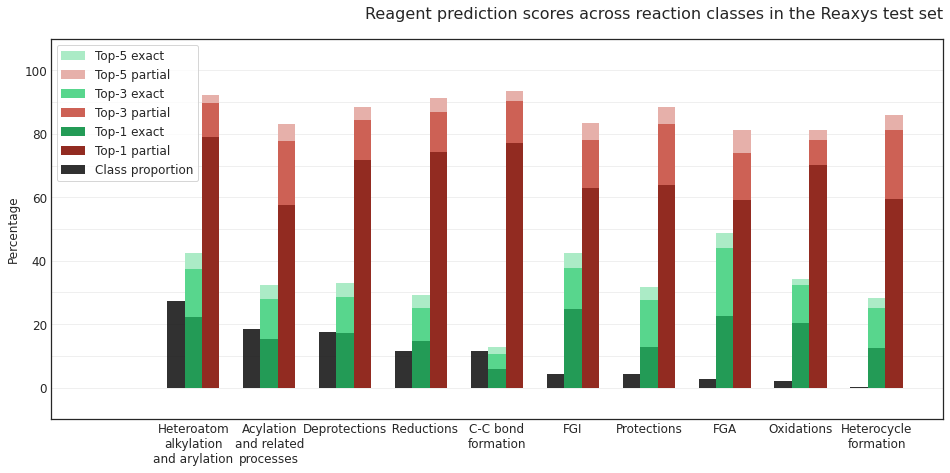

In [297]:
plot_performance_across_classes(
    unique_rxn_perf["General class"], # test["General class"]
    unique_rxn_perf[topn_exact_match_acc.columns], # topn_exact_match_acc
    unique_rxn_perf[topn_partial_match_acc.columns], # topn_partial_match_acc 
    figsize=(16, 7),
    width=0.23,
    fontsize=18
)
plt.savefig("reaxys_classes_new.pdf", dpi=600)
plt.show()

Correlates with the TSNE maps similarity of corresponding reaction classes

# Performance across reagent roles

### Roles of the target reagents

In [203]:
test_r_roles = pd.concat(
        (
            test["General class"],
            tgt_for_rgs.apply(HeuristicRoleClassifier.classify_to_str).str.split("&", expand=True)
        ),
        axis=1
    )
test_r_roles.columns = ["General class"] + [f"tgt_{r}" for r in HeuristicRoleClassifier.types]
test_r_roles.head()

,General class,tgt_Catalyst,tgt_Ox,tgt_Red,tgt_Acid,tgt_Base,tgt_Unspecified,tgt_Solvent
0,Deprotections,[Pd],,[H][H],,,,CO
1,Deprotections,[Pd],,[H][H],,,,CC(C)O
2,Deprotections,[Pd+2],,[H][H],,[OH-].[OH-],,CCO
3,Deprotections,[Pd],,[H][H],,,,CO
4,Deprotections,[Pd],,[H][H],,,,CO


In [254]:
test_r_roles.iloc[10000:10005]

,General class,tgt_Catalyst,tgt_Ox,tgt_Red,tgt_Acid,tgt_Base,tgt_Unspecified,tgt_Solvent
10000,Acylation and related processes,,,,,,[K],CO
10001,Acylation and related processes,,,,,,[CH2-]CCC.[Li+],C1CCOC1.CCCCCC
10002,Protections,,,,,O=C([O-])[O-],[Na+].[Na+].O,C1CCOC1
10003,Acylation and related processes,,,,Cl,CCN(CC)CC,,ClCCl
10004,Acylation and related processes,,,,,,,ClCCl


### Roles of the predicted reagents for each of the N predictions

In [223]:
n = pred_rgs.shape[1]
top_n_roles = {}
for i in range(1, n + 1):
    _temp = pred_rgs[f"p_reagents_{i}"].apply(
        HeuristicRoleClassifier.classify_to_str
    ).str.split("&",
                expand=True)
    _temp.columns = [f"pred_{r}" for r in HeuristicRoleClassifier.types]
    top_n_roles[i] = _temp

In [224]:
for i in top_n_roles:
    print(f"Pred {i}")
    display(top_n_roles[i].head())

Pred 1


,pred_Catalyst,pred_Ox,pred_Red,pred_Acid,pred_Base,pred_Unspecified,pred_Solvent
0,[Pd],,,,,,CO
1,[Pd],,,,,,CCO
2,[Pd],,,,,,CCO
3,[Pd],,,,,,CCO
4,[Pd],,,[NH4+],O=C[O-],,CO


Pred 2


,pred_Catalyst,pred_Ox,pred_Red,pred_Acid,pred_Base,pred_Unspecified,pred_Solvent
0,[Pd],,,,,,CCO
1,[Pd],,,,,,CO
2,[Pd],,,,,,CO
3,[Pd],,,,,,CO
4,[Pd+2],,,,[OH-].[OH-],,CO


Pred 3


,pred_Catalyst,pred_Ox,pred_Red,pred_Acid,pred_Base,pred_Unspecified,pred_Solvent
0,[Pd],,[H][H],,,,CO
1,[Pd],,,[NH4+],O=C[O-],,CO
2,[Pd+2],,,,[OH-].[OH-],,CO
3,[Pd],,[H][H],,,,CO
4,[Pd],,,,,,CCO


Pred 4


,pred_Catalyst,pred_Ox,pred_Red,pred_Acid,pred_Base,pred_Unspecified,pred_Solvent
0,[Pd+2],,,,[OH-].[OH-],,CO
1,[Pd+2],,,,[OH-].[OH-],,CCO
2,[Pd+2],,,,[OH-].[OH-],,CCO
3,[Pd+2],,,,[OH-].[OH-],,CO
4,[Pd+2],,,,[OH-].[OH-],,CCO


Pred 5


,pred_Catalyst,pred_Ox,pred_Red,pred_Acid,pred_Base,pred_Unspecified,pred_Solvent
0,[Pd],,[H][H],,,,CCO
1,[Pd+2],,,,[OH-].[OH-],,CO
2,[Pd],,[H][H],,,,CO
3,[Pd],,[H][H],,,,CCO
4,[Pd],,[H][H],,,,CO


### Top-N exact match of predictions for each role

In [225]:
role_performance = {}
for r in HeuristicRoleClassifier.types:
    
    tgt_and_pred_roles = pd.concat(
        [test_r_roles[f"tgt_{r}"]] + [top_n_roles[i][f"pred_{r}"] for i in range(1, n + 1)],
        axis=1
    )
    perf = tgt_and_pred_roles.apply(
        lambda x: match_accuracy(x, 'exact'),
        axis=1
    )
    perf = pd.DataFrame(perf.to_list())
    perf.columns = [f"top_{i}_exact" for i in range(1, n + 1)]
    role_performance[r] = perf

In [226]:
role_perf_summary = {}
for r in HeuristicRoleClassifier.types:
    nonempty_target = test_r_roles[test_r_roles[f"tgt_{r}"] != ''].index
    role_perf_summary[r] = {
        "Top-1": role_performance[r]["top_1_exact"].mean(),
        "Top-1\nnon-empty\nground truth": role_performance[r].loc[nonempty_target]["top_1_exact"].mean(),
        "Top-5": role_performance[r]["top_5_exact"].mean(),
        "Top-5\nnon-empty\nground truth": role_performance[r].loc[nonempty_target]["top_5_exact"].mean()
    }

In [227]:
role_perf_summary

{'Catalyst': {'Top-1': 0.8353751201811246,
  'Top-1\nnon-empty\nground truth': 0.4288352400684623,
  'Top-5': 0.8854945259436157,
  'Top-5\nnon-empty\nground truth': 0.5849923430321593},
 'Ox': {'Top-1': 0.9737720848969802,
  'Top-1\nnon-empty\nground truth': 0.23178807947019867,
  'Top-5': 0.9840585553453463,
  'Top-5\nnon-empty\nground truth': 0.3646523178807947},
 'Red': {'Top-1': 0.8866730763266445,
  'Top-1\nnon-empty\nground truth': 0.4501915708812261,
  'Top-5': 0.9523100621323491,
  'Top-5\nnon-empty\nground truth': 0.7748171368861024},
 'Acid': {'Top-1': 0.8562995585605144,
  'Top-1\nnon-empty\nground truth': 0.29584352078239606,
  'Top-5': 0.9366684241540799,
  'Top-5\nnon-empty\nground truth': 0.6271023190338594},
 'Base': {'Top-1': 0.6859990282128421,
  'Top-1\nnon-empty\nground truth': 0.5071055576277509,
  'Top-5': 0.7945703977090635,
  'Top-5\nnon-empty\nground truth': 0.6654046997389034},
 'Unspecified': {'Top-1': 0.5019797578802634,
  'Top-1\nnon-empty\nground truth': 

In [228]:
role_perf_summary = pd.DataFrame.from_dict(role_perf_summary)
role_perf_summary

,Catalyst,Ox,Red,Acid,Base,Unspecified,Solvent
Top-1,0.835375,0.973772,0.886673,0.856300,0.685999,0.501980,0.328071
Top-1\nnon-empty\nground truth,0.428835,0.231788,0.450192,0.295844,0.507106,0.335621,0.319355
Top-5,0.885495,0.984059,0.952310,0.936668,0.794570,0.658686,0.577149
Top-5\nnon-empty\nground truth,0.584992,0.364652,0.774817,0.627102,0.665405,0.526891,0.565729


In [229]:
role_perf_summary = role_perf_summary.T
role_perf_summary

,Top-1,Top-1\nnon-empty\nground truth,Top-5,Top-5\nnon-empty\nground truth
Catalyst,0.835375,0.428835,0.885495,0.584992
Ox,0.973772,0.231788,0.984059,0.364652
Red,0.886673,0.450192,0.952310,0.774817
Acid,0.856300,0.295844,0.936668,0.627102
Base,0.685999,0.507106,0.794570,0.665405
Unspecified,0.501980,0.335621,0.658686,0.526891
Solvent,0.328071,0.319355,0.577149,0.565729


/home/mandronov/anaconda3/envs/reagents_pred/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


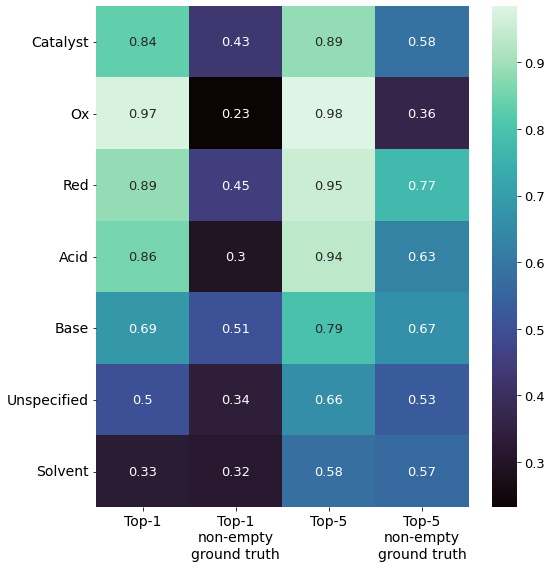

In [230]:
plt.figure(figsize=(8, 8))
sns.heatmap(role_perf_summary, 
            annot=True, 
            annot_kws={"fontsize": 13},
            cmap="mako", 
            ax=plt.gca())
# plt.title(
#     "Proportion of test examples on which the prediction\nmatches the ground truth exactly in each reagent role.",
#     fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=0, fontsize=14)
ax = plt.gca()
ax.figure.axes[-1].yaxis.set_ticklabels(ax.figure.axes[-1].yaxis.get_ticklabels(), fontsize=13)
plt.sca(ax)
# plt.xticks(fontsize=16)
plt.tight_layout()
# plt.savefig("perf_class_1_new.pdf", dpi=600)
plt.show()

# Distribution of unique reagents by roles

In [288]:
df = pd.DataFrame({'A': ['x', 'x', 'y', 'y'], 'B': ['', '', 'g.h.i', 'j.k.l']})
df

,A,B
0,x,
1,x,
2,y,g.h.i
3,y,j.k.l


In [294]:
df.groupby("A")["B"].apply(lambda x: len(set_of_unique_molecules(x) - {''}))

A
x    0
y    6
Name: B, dtype: int64

In [295]:
def set_of_unique_molecules(smiles: pd.Series):
    return set(sum([i.split('.') for i in smiles], []))

unique_solvents_for_class = pd.concat((test["Class"], test_r_roles), 
          axis=1).groupby("Class")["tgt_Solvent"].apply(lambda x: len(set_of_unique_molecules(x) - {''}))

There are 684 unique reaction classes determined by NameRXN. Only 439 classes occur more than once. Only 20 classes occur more than 1000 times. Only 87 types occur more than 100 times. 245 classes occur once. 477 classes occur 10 times or less.

In [340]:
439 / 684

0.6418128654970761

In [351]:
from collections import Counter

In [347]:
singular_classes = test["Class"].value_counts()[test["Class"].value_counts() == 1].index
very_rare_classes = test["Class"].value_counts()[(test["Class"].value_counts() <= 10) & (test["Class"].value_counts() > 1)].index
rare_classes = test["Class"].value_counts()[(test["Class"].value_counts() <= 100) & (test["Class"].value_counts() > 10)].index
frequent_classes = test["Class"].value_counts()[(test["Class"].value_counts() <= 1000) & (test["Class"].value_counts() > 100)].index
common_classes = test["Class"].value_counts()[test["Class"].value_counts() > 1000].index

In [756]:
test["Class"].value_counts().head(10)

1.7.9 Williamson ether synthesis [O-substitution]                  13101
3.1.1 Bromo Suzuki coupling [Suzuki coupling]                       6706
6.2.2 CO2H-Me deprotection [RCO2H deprotections]                    5116
1.2.1 Aldehyde reductive amination [Reductive amination]            5039
2.3.1 Isocyanate + amine urea coupling [N-acylation to urea]        4879
7.9.1 Aldehyde to alcohol reduction [Other reductions]              3470
2.1.10 Carboxylic ester + amine reaction [N-acylation to amide]     3329
5.1.1 N-Boc protection [NH protections]                             3313
1.3.7 Chloro N-arylation [N-arylation with Ar-X]                    2758
7.3.1 Nitrile reduction [Cyano or imine to amine]                   2646
Name: Class, dtype: int64

In [374]:
class_to_general_class["10.1.1 Bromination [Halogenation]"]

'Functional group addition (FGA)'

In [381]:
class_to_general_class = test.groupby("Class")["General class"].agg(pd.Series.mode)

In [384]:
pd.Series(Counter([class_to_general_class[i] for i in common_classes]))

Heteroatom alkylation and arylation    4
C-C bond formation                     1
Deprotections                          5
Acylation and related processes        5
Reductions                             3
Protections                            1
Functional group addition (FGA)        1
dtype: int64

In [820]:
bin_index = test[test["Class"].apply(lambda x: x in common_classes)].index


unique_rxn_perf = pd.concat(
    (
        src_for_rgs.loc[bin_index],
        topn_exact_match_acc.loc[bin_index],
        topn_partial_match_acc.loc[bin_index],
        (topn_recall == 1).astype(int).loc[bin_index],
        test["General class"].loc[bin_index]
    ), 
    axis=1
)
print(len(unique_rxn_perf))
unique_rxn_perf.columns = ["src"] + list(unique_rxn_perf.columns[1:])
unique_rxn_perf = unique_rxn_perf.groupby(by="src")

unique_exact_matches = [unique_rxn_perf[c].max() for c in topn_exact_match_acc.columns]
unique_partial_matches = [unique_rxn_perf[c].max() for c in topn_partial_match_acc.columns]
unique_recalls = [unique_rxn_perf[c].max() for c in topn_recall.columns]
unique_rxn_types = [unique_rxn_perf["General class"].apply(lambda x: x.iloc[0])]
unique_rxn_perf = pd.concat(
    unique_exact_matches + unique_partial_matches + unique_recalls + unique_rxn_types,
    axis=1
).reset_index()

for c in topn_exact_match_acc.columns:
    print(c, round(100 * unique_rxn_perf[c].mean(), 4))
print()  
for c in topn_partial_match_acc.columns:
    print(c, round(100 * unique_rxn_perf[c].mean(), 4))
print()
for c in topn_recall.columns:
    print(c, round(100 * unique_rxn_perf[c].mean(), 4))

67633
top_1_exact 17.0415
top_2_exact 25.2684
top_3_exact 30.1399
top_4_exact 32.8844
top_5_exact 34.6757

top_1_partial 73.543
top_2_partial 82.9684
top_3_partial 87.2094
top_4_partial 89.2657
top_5_partial 90.5614

top_1_recall 19.2822
top_2_recall 29.1554
top_3_recall 36.2809
top_4_recall 40.7162
top_5_recall 44.3135


,top_1_exact,top_2_exact,top_3_exact,top_4_exact,top_5_exact
0,0,0,1,1,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,1,1,1
4,0,0,0,0,1
...,...,...,...,...,...
96724,0,0,0,0,0
96725,0,0,0,0,0
96726,0,0,0,0,0
96727,0,0,0,0,0


In [754]:
common_classes

Index(['1.7.9 Williamson ether synthesis [O-substitution]',
       '3.1.1 Bromo Suzuki coupling [Suzuki coupling]',
       '6.2.2 CO2H-Me deprotection [RCO2H deprotections]',
       '1.2.1 Aldehyde reductive amination [Reductive amination]',
       '2.3.1 Isocyanate + amine urea coupling [N-acylation to urea]',
       '7.9.1 Aldehyde to alcohol reduction [Other reductions]',
       '2.1.10 Carboxylic ester + amine reaction [N-acylation to amide]',
       '5.1.1 N-Boc protection [NH protections]',
       '1.3.7 Chloro N-arylation [N-arylation with Ar-X]',
       '7.3.1 Nitrile reduction [Cyano or imine to amine]',
       '6.3.7 Methoxy to hydroxy [ROH deprotections]',
       '6.2.1 CO2H-Et deprotection [RCO2H deprotections]',
       '1.2.4 Eschweiler-Clarke methylation [Reductive amination]',
       '6.1.5 N-Bn deprotection [NH deprotections]',
       '2.1.2 Carboxylic acid + amine condensation [N-acylation to amide]',
       '2.2.3 Sulfonamide Schotten-Baumann [N-sulfonylation]',
     

In [333]:
pd.concat((test["Class"], test[f"Reagents"], topn_exact_match_acc), axis=1)

,Class,Reagents,top_1_exact,top_2_exact,top_3_exact,top_4_exact,top_5_exact
0,6.1.5 N-Bn deprotection [NH deprotections],[H][H].[Pd].CO,0,0,1,1,1
1,6.1.5 N-Bn deprotection [NH deprotections],[H][H].CC(C)O.[Pd],0,0,0,0,0
2,6.1.5 N-Bn deprotection [NH deprotections],[Pd+2].[H][H].[OH-].[OH-].CCO,0,0,0,0,0
3,6.1.5 N-Bn deprotection [NH deprotections],[H][H].[Pd].CO,0,0,1,1,1
4,6.1.5 N-Bn deprotection [NH deprotections],[H][H].[Pd].CO,0,0,0,0,1
...,...,...,...,...,...,...,...
96724,7.9.1 Aldehyde to alcohol reduction [Other red...,CC(=O)O.[Pd+2].[H][H].[OH-].[OH-].CO,0,0,0,0,0
96725,7.9.1 Aldehyde to alcohol reduction [Other red...,[OH-].[K+].CO,0,0,0,0,0
96726,7.9.1 Aldehyde to alcohol reduction [Other red...,[OH-].[K+].CO,0,0,0,0,0
96727,7.9.1 Aldehyde to alcohol reduction [Other red...,[H][H].CC(C)O.[Pd].O,0,0,0,0,0


In [393]:
r = "Ox"
pd.concat((test["Class"], 
           test_r_roles[f"tgt_{r}"], 
           role_performance[r]), axis=1).groupby("Class")[f"tgt_{r}"].apply(lambda x: len(set_of_unique_molecules(x) - {''}))[common_classes]

1.7.9 Williamson ether synthesis [O-substitution]                    14
3.1.1 Bromo Suzuki coupling [Suzuki coupling]                        15
6.2.2 CO2H-Me deprotection [RCO2H deprotections]                      5
1.2.1 Aldehyde reductive amination [Reductive amination]              6
2.3.1 Isocyanate + amine urea coupling [N-acylation to urea]          2
7.9.1 Aldehyde to alcohol reduction [Other reductions]               11
2.1.10 Carboxylic ester + amine reaction [N-acylation to amide]       4
5.1.1 N-Boc protection [NH protections]                               8
1.3.7 Chloro N-arylation [N-arylation with Ar-X]                      8
7.3.1 Nitrile reduction [Cyano or imine to amine]                    11
6.3.7 Methoxy to hydroxy [ROH deprotections]                          5
6.2.1 CO2H-Et deprotection [RCO2H deprotections]                      7
1.2.4 Eschweiler-Clarke methylation [Reductive amination]             1
6.1.5 N-Bn deprotection [NH deprotections]                      

In [ ]:
3.1.2 Chloro Suzuki coupling [Suzuki coupling]                  1
9.1.10 Darzens chlorination [Alcohol to halide]                 1
3.3.2 Bromo Sonogashira coupling [Sonogashira reaction]         1
1.8.13 Chloro thioether synthesis [S-substitution]              1
3.11.91 Keto alpha-alkylation [Other C-C bond formation]        1
1.8.12 Bromo thioether synthesis [S-substitution]               1
1.1.7 Iodo Menshutkin reaction [N-substitution with alkyl-X]    1                              1                                 1                                                                     1

In [912]:
r

'Acid'

In [926]:
_a = test_r_roles.loc[test[test["Class"] == "1.1.7 Iodo Menshutkin reaction [N-substitution with alkyl-X]"].index]
# _a[_a["tgt_Solvent"] == "ClCCl"]

In [927]:
_a[f"tgt_{r}"].value_counts(normalize=False)

      108
Cl      1
Name: tgt_Acid, dtype: int64

In [862]:
_a

,General class,tgt_Catalyst,tgt_Ox,tgt_Red,tgt_Acid,tgt_Base,tgt_Unspecified,tgt_Solvent
32213,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl
32443,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl.ClCCl
32482,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl
32491,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl
32516,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl
32520,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl
32531,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl
32534,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,CS(C)=O.ClCCl
32554,Oxidations,,O=C(Cl)C(=O)Cl,,,CCN(CC)CC,,ClCCl
32558,Oxidations,,O=C(Cl)C(=O)Cl,,,,,CS(C)=O.ClCCl


In [863]:
pred_rgs.loc[_a[_a[f"tgt_{r}"] != ''].index]

,p_reagents_1,p_reagents_2,p_reagents_3,p_reagents_4,p_reagents_5
32213,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,[Mn+4].[O-2].[O-2].ClCCl,CCN(CC)CC.CS(C)=O,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl.ClCCl
32443,[Mn+4].[O-2].[O-2].ClCCl,[Mn+4].[O-2].[O-2].ClC(Cl)Cl,[Mn+4].[O-2].[O-2],O=[Mn]=O.ClCCl,[Mn+4].[O-2].[O-2].ClC(Cl)Cl.CO
32482,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,[Cr+6].[O-2].[O-2].[O-2].c1ccncc1.ClCCl,[Mn+4].[O-2].[O-2].ClCCl,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl.CCOCC,O=C(Cl)C(=O)Cl.CCN(CC)CC.CS(C)=O
32491,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,[Mn+4].[O-2].[O-2].ClCCl,[Cr+6].[O-2].[O-2].[O-2].c1ccncc1.ClCCl,[Mn+4].[O-2].[O-2].ClC(Cl)Cl,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1
32516,[Mn+4].[O-2].[O-2].ClCCl,CC(=O)OI1(OC(C)=O)(OC(C)=O)OC(=O)c2ccccc21.ClCCl,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,O=C(Cl)C(=O)Cl.CCN(CC)CC.CS(C)=O.ClCCl,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl.CCOCC
32520,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,[Mn+4].[O-2].[O-2].ClCCl,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1,CCN(CC)CC.O.CS(C)=O,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl.ClCCl
32531,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,[Mn+4].[O-2].[O-2].ClCCl,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl.CCOCC,O=S(=O)(O)O.O=[Cr](=O)=O.CC(C)=O,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl.ClCCl
32534,[Mn+4].[O-2].[O-2].ClCCl,[Mn+4].[O-2].[O-2],[Mn+4].[O-2].[O-2].ClC(Cl)Cl,[Mn+4].[O-2].[O-2].CCCCCC,[Mn+4].[O-2].[O-2].CCCCCC.ClCCl
32554,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,[Mn+4].[O-2].[O-2].ClCCl,CC(=O)OI1(OC(C)=O)(OC(C)=O)OC(=O)c2ccccc21.ClCCl,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl.CCOCC,O=[Mn]=O.ClCCl
32558,O=[Cr](=O)([O-])Cl.c1cc[nH+]cc1.ClCCl,CC(=O)OI1(OC(C)=O)(OC(C)=O)OC(=O)c2ccccc21.ClCCl,O=C(Cl)C(=O)Cl.CCN(CC)CC.CS(C)=O.ClCCl,[Mn+4].[O-2].[O-2].ClCCl,O=[Cr](=O)([O-])O[Cr](=O)(=O)[O-].c1cc[nH+]cc1...


In [908]:
role_performance[r].loc[_a[_a[f"tgt_{r}"] != ''].index]["top_1_exact"].mean()

0.013333333333333334

In [558]:
test.loc[36445]

Reaction ID                                                    5082114
Reaction             CC1=CC=C2N=C(C)C(C)=NC2=C1O.CI>>[O-][Cl](=O)(=...
Year                                                              1998
Reagent SMILES                                  [O-]Cl(=O)(=O)=O.[Ag+]
Solvent SMILES                                                 C(Cl)Cl
Catalyst SMILES                                                       
Class                1.1.7 Iodo Menshutkin reaction [N-substitution...
General class                      Heteroatom alkylation and arylation
FullR                Cc1ccc2nc(C)c(C)nc2c1O.CI>[O-][Cl+3]([O-])([O-...
Reactants                                    Cc1ccc2nc(C)c(C)nc2c1O.CI
Reagents                        [O-][Cl+3]([O-])([O-])[O-].ClCCl.[Ag+]
Product                                   Cc1ccc2c(nc(C)c(C)[n+]2C)c1O
ReactionRgsSource    Cc1ccc2nc(C)c(C)nc2c1O.CI>>Cc1ccc2c(nc(C)c(C)[...
References           Article; Rtishchev; Selitrenikov; El'tsov; Rus...
Name: 

In [658]:
test.loc[3962]["References"]

'Article; Rao, Honghua; Jin, Ying; Fu, Hua; Jiang, Yuyang; Zhao, Yufen; Chemistry - A European Journal; vol. 12; 13; (2006); p. 3636 - 3646;'

In [571]:
pred_rgs.loc[_a[_a["tgt_Solvent"] == "ClCCl"].index]

,p_reagents_1,p_reagents_2,p_reagents_3,p_reagents_4,p_reagents_5
10099,CCN(CC)CC.ClCCl,[H-].[Na+].C1CCOC1,ClCCl,c1ccncc1,CCN(CC)CC
10189,CCN(CC)CC.ClCCl,[H-].[Na+].C1CCOC1,c1ccncc1.ClCCl,c1ccncc1,CCN(CC)CC
10190,CCN(CC)CC.ClCCl,[H-].[Na+].C1CCOC1,ClCCl,c1ccncc1,CCN(CC)CC
10191,[OH-].[Na+],[OH-].[Na+].O.Cc1ccccc1,[OH-].[Na+].O,[OH-].[Na+].O.c1ccccc1,[OH-].[Na+].O.ClCCl
10192,CCN(CC)CC.ClCCl,CCN(CC)CC.O.ClCCl,CCN(CC)CC,c1ccncc1,CCN(CC)CC.CCOCC
10193,CCN(CC)CC.ClCCl,[H-].[Na+].C1CCOC1,CCN(CC)CC,c1ccncc1,ClCCl
10194,CCN(CC)CC.ClCCl,[H-].[Na+].C1CCOC1,[H-].[Na+].O.C1CCOC1,CCN(CC)CC.ClC(Cl)Cl,CCN(CC)CC.O.ClCCl
10197,CCN(CC)CC.ClCCl,[H-].[Na+].C1CCOC1,Cl,CCN(CC)CC,c1ccncc1


In [469]:
test_r_roles.loc[68]

General class                                          Deprotections
tgt_Catalyst                                                  [Ce+4]
tgt_Ox                                                              
tgt_Red                                                             
tgt_Acid                                                      [NH4+]
tgt_Base                                                            
tgt_Unspecified    O=[N+]([O-])[O-].O=[N+]([O-])[O-].O=[N+]([O-])...
tgt_Solvent                                            CC(=O)O.ClCCl
Name: 68, dtype: object

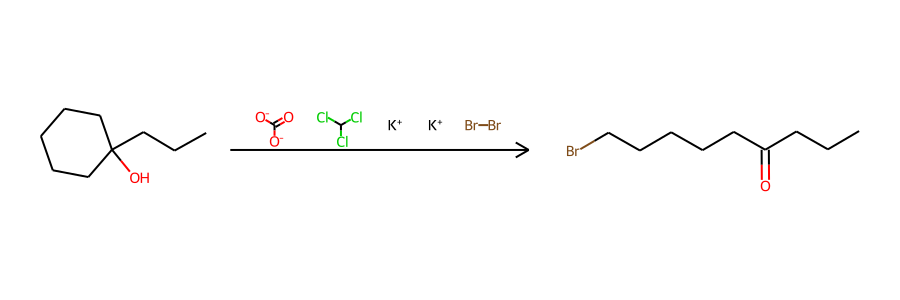

In [753]:
ut.draw_reaction_smarts(test.loc[51512].FullR)

In [434]:
_tmp

,Class,tgt_Catalyst,top_1_exact,top_2_exact,top_3_exact,top_4_exact,top_5_exact
0,6.1.5 N-Bn deprotection [NH deprotections],[Pd],1,1,1,1,1
1,6.1.5 N-Bn deprotection [NH deprotections],[Pd],1,1,1,1,1
2,6.1.5 N-Bn deprotection [NH deprotections],[Pd+2],0,0,1,1,1
3,6.1.5 N-Bn deprotection [NH deprotections],[Pd],1,1,1,1,1
4,6.1.5 N-Bn deprotection [NH deprotections],[Pd],1,1,1,1,1
...,...,...,...,...,...,...,...
96724,7.9.1 Aldehyde to alcohol reduction [Other red...,[Pd+2],0,0,0,1,1
96725,7.9.1 Aldehyde to alcohol reduction [Other red...,,1,1,1,1,1
96726,7.9.1 Aldehyde to alcohol reduction [Other red...,,1,1,1,1,1
96727,7.9.1 Aldehyde to alcohol reduction [Other red...,[Pd],1,1,1,1,1


In [431]:
_acc

'top_1_exact'

In [928]:
r = "Catalyst"
_tmp = pd.concat((test["Class"], test_r_roles[f"tgt_{r}"], role_performance[r]), axis=1)
_tmp
_tmp_unique_molecules_for_class = _tmp.groupby("Class")[f"tgt_{r}"].apply(lambda x: len(set_of_unique_molecules(x) - {''}))[very_rare_classes]
_tmp_unique_molecules_for_class[_tmp_unique_molecules_for_class == 1] #.sort_values(ascending=True).head(23)
# _tmp_mean_top1_exact_acc = _tmp.groupby("Class")[_acc].mean()[common_classes]
# _tmp_mean_top1_exact_acc

# _tmp_unique_molecules_for_class = _tmp_unique_molecules_for_class.apply(lambda x: "3+" if x > 2 else x)

# # Number of types with a given number of unique molecules in a certain role
# _df = pd.concat((_tmp_unique_molecules_for_class, _tmp_mean_top1_exact_acc), 
#               axis=1)
# _rows_count.append(
#         _df.groupby(by=f"tgt_{r}")[_acc].count()
#     )
# _rows_acc.append(
#         _df.groupby(by=f"tgt_{r}")[_acc].mean()
#     )

5.1.6 N-Bn protection [NH protections]                                                                       1
8.1.17 Oppenauer-Woodward oxidation [Alcohols to aldehydes]                                                  1
8.1.37 Pfitzner-Moffatt aldehyde oxidation [Alcohols to aldehydes]                                           1
1.7.56 Peroxy ether synthesis [O-substitution]                                                               1
10.1.29 Silane chlorination [Halogenation]                                                                   1
1.7.14 O-methylation [O-substitution]                                                                        1
1.7.16 Aziridine + alcohol coupling [O-substitution]                                                         1
3.11.17 Wurtz-type coupling [Other C-C bond formation]                                                       1
6.1.29 N-Ethyl carbamate deprotection [NH deprotections]                                                     1
8

In [838]:
rare_classes

Index(['1.8.7 Migita thioether synthesis [S-substitution]',
       '9.1.8 Hydroxy to iodo [Alcohol to halide]',
       '1.3.14 Tosyloxy N-arylation [N-arylation with Ar-X]',
       '2.6.17 Carbonodithioate synthesis [O-acylation to ester]',
       '1.2.9 Alcohol + amine condensation [Reductive amination]',
       '3.4.6 Triflyloxy Stille reaction [Stille reaction]',
       '1.7.2 Diazomethane esterification [O-substitution]',
       '2.7.2 Sulfonic ester Schotten-Baumann [O-sulfonylation]',
       '1.3.9 Iodo N-arylation [N-arylation with Ar-X]',
       '1.8.15 Iodo thioether synthesis [S-substitution]',
       ...
       '1.3.7;6.1.1 Chloro N-arylation;N-Boc deprotection [N-arylation with Ar-X;NH deprotections]',
       '6.3.13 O-SEM deprotection [ROH deprotections]',
       '6.1.2 N-Bz deprotection [NH deprotections]',
       '3.11.52 Cyanoalkane alkylation [Other C-C bond formation]',
       '7.6.1;6.1.5 Alkene hydrogenation;N-Bn deprotection [Alkene to alkane;NH deprotections]',
  

In [841]:
_rows_count = []
_rows_acc = []
_acc = "top_1_exact"
for r in HeuristicRoleClassifier.types:
    _tmp = pd.concat((test["Class"], test_r_roles[f"tgt_{r}"], role_performance[r]), axis=1)
    _tmp_unique_molecules_for_class = _tmp.groupby("Class")[f"tgt_{r}"].apply(lambda x: len(set_of_unique_molecules(x) - {''}))[frequent_classes]
    _tmp_mean_top1_exact_acc = _tmp.groupby("Class")[_acc].mean()[frequent_classes]

    _tmp_unique_molecules_for_class = _tmp_unique_molecules_for_class.apply(lambda x: "3+" if x > 2 else x)

    # Number of types with a given number of unique molecules in a certain role
    _df = pd.concat((_tmp_unique_molecules_for_class, _tmp_mean_top1_exact_acc), 
              axis=1)
    _rows_count.append(
        _df.groupby(by=f"tgt_{r}")[_acc].count()
    )
    _rows_acc.append(
        _df.groupby(by=f"tgt_{r}")[_acc].mean()
    )
res_count = pd.concat(_rows_count, axis=1)
res_count.columns = HeuristicRoleClassifier.types
res_mean = pd.concat(_rows_acc, axis=1)
res_mean.columns = HeuristicRoleClassifier.types

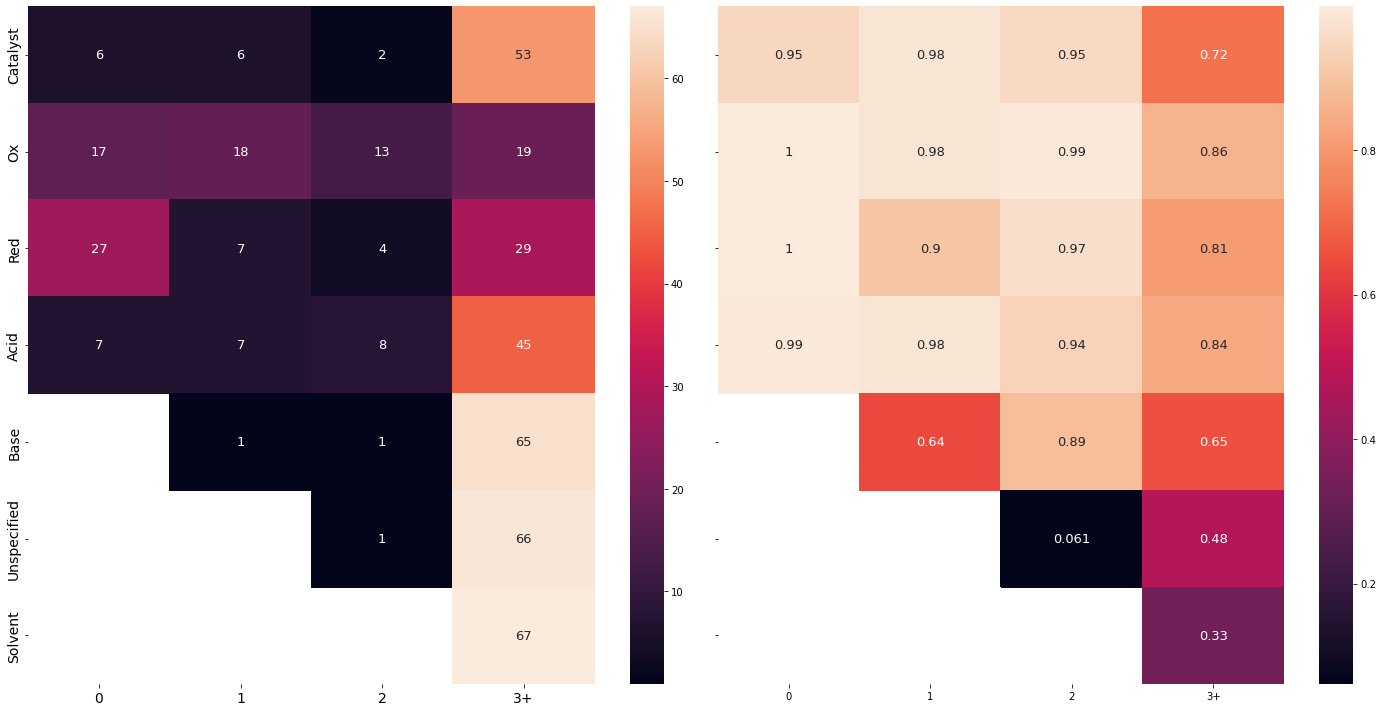

In [842]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(20, 10))
angle = 0
annot_size = 13
title_size = 16
tick_size = 14
pad = 20

sns.heatmap(res_count.T, 
            annot=True, 
            ax=ax[0], 
            annot_kws={"fontsize": annot_size},
            fmt='.3g')

plt.sca(ax[0])
plt.ylabel(None)
plt.xlabel(None)

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,
#     labeltop=True) # labels along the bottom edge are off
plt.xticks(rotation=angle, fontsize=tick_size)
# plt.title("Top-1 accuracy of predictions by roles across classes", fontsize=title_size, loc="right", pad=pad, fontweight='bold')
plt.yticks(fontsize=tick_size)


sns.heatmap(res_mean.T, 
            annot=True, 
            annot_kws={"size": annot_size},
            # fmt='d',
            ax=ax[1])
plt.sca(ax[1])
# plt.title("Number of non-empty ground truth SMILES", fontsize=title_size, loc="right", pad=pad, fontweight='bold')
plt.ylabel(None)
plt.xlabel(None)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.xticks(rotation=angle, fontsize=14)
plt.yticks(fontsize=tick_size)

# fig.suptitle("Performance of reagent prediction across reaction classes and reagent roles", fontsize=16)
plt.tight_layout()
# plt.savefig("perf_class_2_new.png", dpi=300)
plt.show()

/home/mandronov/anaconda3/envs/reagents_pred/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


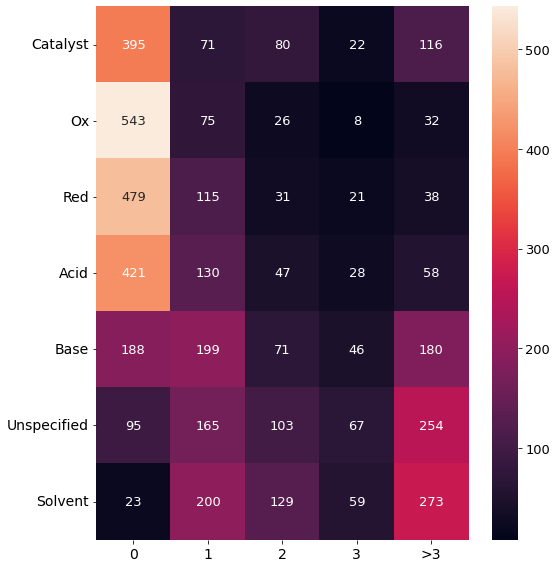

In [302]:
plt.figure(figsize=(8, 8))
sns.heatmap(res_count.T, 
            annot=True, 
            annot_kws={"fontsize": 13},
            # cmap="mako", 
            fmt='d',
            ax=plt.gca())
# plt.title(
#     "Proportion of test examples on which the prediction\nmatches the ground truth exactly in each reagent role.",
#     fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=0, fontsize=14)
ax = plt.gca()
ax.figure.axes[-1].yaxis.set_ticklabels(ax.figure.axes[-1].yaxis.get_ticklabels(), fontsize=13)
plt.sca(ax)
plt.tight_layout()
# plt.savefig("perf_class_1_new.pdf", dpi=600)
plt.show()

# Performance on reaction classes vs reagent roles

In [ ]:
role_top_1_match_by_class = []
role_top_1_match_by_class_nonempty = []
role_nonempty_count = []

for r in HeuristicRoleClassifier.types:
    
    # Stacking the groung truth reagents in one role against prediction performance on that role
    _temp = pd.concat(
        (
            test_r_roles[["General class", f"tgt_{r}"]], 
            role_performance[r]
        ),
        axis=1
    )
    # Need to be careful with empty GT
    _temp["tgt_nonempty"] = _temp[f"tgt_{r}"].apply(lambda x: x != '')
    
    # Proportion of matches by class
    role_top_1_match_by_class.append(
        _temp.groupby(by="General class")["top_1_exact"].mean()
    )
    
    # Proportion of matches by class for nonempty GT
    role_top_1_match_by_class_nonempty.append(
        _temp[_temp["tgt_nonempty"]].groupby(by="General class")["top_1_exact"].mean()
    )
    
    # Number of nonempty GT per class
    role_nonempty_count.append(
        _temp.groupby(by="General class")["tgt_nonempty"].sum()
    )

# Concatenating information for each role    

role_top_1_match_by_class = pd.concat(role_top_1_match_by_class, axis=1)
role_top_1_match_by_class.columns = HeuristicRoleClassifier.types
role_top_1_match_by_class = role_top_1_match_by_class.T

role_top_1_match_by_class_nonempty = pd.concat(role_top_1_match_by_class_nonempty, axis=1)
role_top_1_match_by_class_nonempty.columns = HeuristicRoleClassifier.types
role_top_1_match_by_class_nonempty = role_top_1_match_by_class_nonempty.T

role_nonempty_count = pd.concat(role_nonempty_count, axis=1)
role_nonempty_count.columns = HeuristicRoleClassifier.types
role_nonempty_count = role_nonempty_count.T

In [ ]:
xticklabels = [
    'Acylation\nand related\nprocesses', 
    'C-C bond\nformation',
    'Deprotections', 
    'Functional\ngroup\naddition\n(FGA)',
    'Functional\ngroup\ninterconversion\n(FGI)',
    'Heteroatom\nalkylation\nand arylation', 
    'Heterocycle\nformation',
    'Oxidations', 
    'Protections', 
    'Reductions'
]

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(20, 20))
angle = 0
annot_size = 13
title_size = 16
tick_size = 14
pad = 20

sns.heatmap(role_top_1_match_by_class, 
            annot=True, 
            ax=ax[0], 
            annot_kws={"fontsize": annot_size},
            xticklabels=xticklabels,
            fmt='.3g',
            cmap="mako")

plt.sca(ax[0])
plt.ylabel(None)
plt.xlabel(None)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labeltop=True) # labels along the bottom edge are off
plt.xticks(rotation=angle, fontsize=tick_size)
plt.title("Top-1 accuracy of predictions by roles across classes", fontsize=title_size, loc="right", pad=pad, fontweight='bold')
plt.yticks(fontsize=tick_size)

sns.heatmap(role_top_1_match_by_class_nonempty, 
            annot=True, 
            ax=ax[1], 
            annot_kws={"size": annot_size},
            xticklabels=xticklabels,
            fmt='.3g',
            cmap="mako")
plt.sca(ax[1])
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# plt.xticks(rotation=angle, fontsize=14)
plt.title("Top-1 accuracy of predictions by roles across classes for nonempty ground truth", fontsize=title_size, loc="right", pad=pad, fontweight='bold')
plt.yticks(fontsize=tick_size)

sns.heatmap(role_nonempty_count, 
            annot=True, 
            xticklabels=xticklabels,
            annot_kws={"size": annot_size},
            fmt='d',
            ax=ax[2], 
            cmap="mako")
plt.sca(ax[2])
plt.title("Number of non-empty ground truth SMILES", fontsize=title_size, loc="right", pad=pad, fontweight='bold')
plt.ylabel(None)
plt.xlabel(None)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# plt.xticks(rotation=angle, fontsize=14)
plt.yticks(fontsize=tick_size)

# fig.suptitle("Performance of reagent prediction across reaction classes and reagent roles", fontsize=16)
plt.tight_layout()
plt.savefig("perf_class_2_new.png", dpi=300)
plt.show()

# Comparing the number of predicted molecules with the length of GT

In [ ]:
n_tgt_mols = test["Reagents"].apply(lambda x: len(x.split('.')))

In [ ]:
def label_difference(n: int):
    if n == 0:
        return "Same"
    elif n < 0:
        return "Less"
    else:
        return "More"

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=pred_rgs.shape[1], sharey=True, figsize=(14, 4))
order = ["Less", "Same", "More"]
for i in range(pred_rgs.shape[1]):
    n_pred_mols = pred_rgs[f"p_reagents_{i + 1}"].apply(lambda x: len(x.split('.')))
    (n_pred_mols - n_tgt_mols).apply(label_difference).value_counts(normalize=True).loc[order].plot(kind='bar', ax=ax[i])
    ax[i].set_title(f"Prediction {i + 1}")

fig.suptitle("Number of predicted molecules compared to the number of molecules in GT")
plt.show()

The model tends to predict less molecules than needed

# Unique reagents in test

In [ ]:
unique_reagents = ut.get_reagent_statistics(test["Reagents"])

In [ ]:
print("Unique reagents in the test set")
len(unique_reagents)

In [ ]:
print("Unique reagents if they are repeated more than 20 times")
len([(k, v) for k, v in unique_reagents.items() if v >= 20])

# Performance across target lengths

### Across the number of molecules in target

In [ ]:
topn_exact_match_acc

In [ ]:
pd.concat(
    (test["Reagents"].apply(lambda x: len(x.split('.'))),
     topn_exact_match_acc),
     axis=1
).groupby(by="Reagents")["top_1_exact"].mean().plot(kind='bar')

In [ ]:
pd.concat(
    (test["Reagents"].apply(lambda x: len(x.split('.'))),
     topn_partial_match_acc),
     axis=1
).groupby(by="Reagents")["top_1_partial"].mean().plot(kind='bar')

### Across the target string length

In [ ]:
plt.figure(figsize=(13, 5))

plt.plot(
    pd.concat(
        (test["Reagents"].apply(len),
         topn_exact_match_acc),
         axis=1
    ).groupby(by="Reagents")["top_1_exact"].mean(),
    '-x'
)

plt.show()

In [ ]:
plt.figure(figsize=(13, 5))

plt.plot(
    pd.concat(
        (test["Reagents"].apply(len),
         topn_partial_match_acc),
         axis=1
    ).groupby(by="Reagents")["top_1_partial"].mean(),
    '-x'
)

plt.show()

Small improvement, like 3 percent points. Measuring performance like that improves the score, more duplicates needed.

# Number of unique predictions and unique GT sequence for each reaction class

In [ ]:
compar = pd.concat((test["General class"], rgs_and_predictions), axis=1)

In [ ]:
compar[compar["General class"] == "Reductions"]["p_reagents_1"].nunique()

In [ ]:
pd.concat(
    [compar.groupby(by="General class")[c].nunique() for c in compar.columns[1:]],
    axis=1
).style.background_gradient(cmap='Blues', axis=1)

Model's predictions are not particularly diverse

# Examples of incorrect predictions

Here the difference in train and test distributions very much manifests itself

In [ ]:
failed_in_exact = test.loc[topn_exact_match_acc[topn_exact_match_acc["top_5_exact"] == 0].index]
failed_in_partial = test.loc[topn_partial_match_acc[topn_partial_match_acc["top_5_partial"] == 0].index]

In [ ]:
c = "C-C bond formation"

In [ ]:
fail = failed_in_partial[failed_in_partial["General class"] == c]
fail_pred = pred_rgs.loc[fail.index]

In [ ]:
ix = iter(fail.index)

In [ ]:
i = next(ix)
print(i)
print("GT:", fail.loc[i]["Reagents"])
display(ut.draw_reaction_smarts(fail.loc[i]["FullR"]))
left, right = fail.loc[i]["ReactionRgsSource"].split(">>")
center = fail_pred.loc[i]["p_reagents_1"]
pr = ">".join((left, center, right))
print("Prediction:", center)
display(ut.draw_reaction_smarts(pr))

### Reactions with zero top-5 recall

In [ ]:
no_recall_index = topn_recall[topn_recall["top_5_recall"] == 0.0].index

In [ ]:
no_recall = test.loc[no_recall_index]
no_recall_pred = pred_rgs.loc[no_recall_index]

In [ ]:
test["General class"].value_counts()

In [ ]:
failing_classes = no_recall["General class"].value_counts().loc[test["General class"].value_counts().index] / test["General class"].value_counts()
failing_classes = failing_classes.sort_values()

In [ ]:
failing_classes

In [ ]:
plt.figure(figsize=(20, 5))
plt.bar(
    list(failing_classes.index),
    list(failing_classes)
)
plt.xticks(rotation=15, fontsize=11)
plt.grid(axis='y')
plt.title("Proportion of reactions in a class with zero top-5 recall within the test set")
plt.savefig("/home/mandronov/Pictures/no_recall.png")
plt.show()

In [ ]:
no_recall = no_recall[no_recall["General class"] == 'Functional group addition (FGA)']

In [ ]:
ix = iter(no_recall.index)

In [ ]:
i = next(ix)
print(i)
print("GT:", no_recall.loc[i]["Reagents"])
display(ut.draw_reaction_smarts(no_recall.loc[i]["FullR"]))
left, right = no_recall.loc[i]["ReactionRgsSource"].split(">>")
center = no_recall_pred.loc[i]["p_reagents_1"]
pr = ">".join((left, center, right))
print("Prediction:", center)
display(ut.draw_reaction_smarts(pr))

# Attention patterns

In [ ]:
test[test["General class"] == "Reductions"]

In [ ]:
rgs_and_predictions.loc[12766:12788]

In [ ]:
att_sample_rxn = test.loc[12786]["ReactionRgsSource"]
print(att_sample_rxn)
ut.draw_reaction_smarts(att_sample_rxn)

In [ ]:
sample_path_in = f"../data/test/att_sample.txt"
sample_path_out = f"../experiments/results/att_sample.txt"

In [ ]:
sample_pred = MTReagentPredictor(VOCAB, None, None, None)
tokenized_sample = " ".join(
    sample_pred.tokenizer_source.tokenize([att_sample_rxn])[0][1:-1]
)
with open(sample_path_in, "w") as f:
    f.write(tokenized_sample)

In [ ]:
tokenized_sample

In [ ]:
command = [
    "python3", "/home/mandronov/work/reagents/translate.py",
    "-model", MODEL,
    "-src", sample_path_in,
    "-output", sample_path_out,
    "-batch_size", "32",
    "-max_length", "200",
    "-beam_size", "5",
    "-n_best", "5", 
    "-attn_debug", "-replace_unk", "-fast",
    "-gpu", "0"]

att_w = subprocess.check_output(command)

In [ ]:
att_w = att_w.decode('utf-8').split("\n")

In [ ]:
source_tokens = att_w[0].split()

In [ ]:
lines = [i.split() for i in att_w[1:] if (i and not i.startswith("PRED"))]

output_tokens = []
scores = []
for line in lines:
    output_tokens.append(line[0])
    scores.append([float(j.strip('*')) for j in line[1:]])
scores = pd.DataFrame(scores)
scores.index = output_tokens
scores.columns = source_tokens

In [ ]:
plt.figure(figsize=(15, 10))
axx = plt.gca()
sns.heatmap(scores, cmap="rocket_r", ax=axx, xticklabels=True, yticklabels=True)
axx.tick_params(axis='both', which='both', length=0, labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)

axx.set_xlabel("Source sequence", fontsize=16)
axx.set_ylabel("Output sequence", fontsize=16)
axx.xaxis.set_label_position('top') 
plt.xticks(rotation=0, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.show()

In [ ]:
left, right = "".join(source_tokens).split(">>")
decoded_reaction = left + ">" + "".join(output_tokens[:-1]) + ">" + right

In [ ]:
print(decoded_reaction)
ut.draw_reaction_smarts(decoded_reaction)

# Inspecting the replaced reagents in the MIT subset of USPTO

In [ ]:
path = "../data/tokenized/MIT_separated"
arrow = ">"

In [ ]:
subset = "train" # "val"

In [ ]:
with open(path + f"/src-{subset}.txt") as f, open(path + f"_no_reags/src-{subset}.txt") as g, open(path + f"_reags_top1/src-{subset}.txt") as h, open(path + f"_reags_top1_and_rdkit/src-{subset}.txt") as ff, open(path + f"_reags_role_voting/src-{subset}.txt") as gg:
    base = [i.strip().replace(" ", "") for i in f.readlines()]
    no_rgs = [i.strip().replace(" ", "") for i in g.readlines()]
    top = [i.strip().replace(" ", "") for i in h.readlines()]
    mix = [i.strip().replace(" ", "") for i in ff.readlines()]
    role = [i.strip().replace(" ", "") for i in gg.readlines()]
with open(path + f"/tgt-{subset}.txt") as f:
    tgt = [i.strip().replace(" ", "") for i in f.readlines()]

In [ ]:
base = [i + arrow + j for i, j in zip(base, tgt)]
no_rgs = [i + ">>" + j for i, j in zip(no_rgs, tgt)]
top = [i + arrow + j for i, j in zip(top, tgt)]
mix = [i + arrow + j for i, j in zip(mix, tgt)]
role = [i + arrow + j for i, j in zip(role, tgt)]

Examples of indexes of reactions with replaced reagents in train:  
1,   3,   6,   8,  17,  22,  25,  26,  33,  38,  39,  42,  47,
            51,  56,  59,  60,  64,  68,  76,  81,  83,  84,  87,  91,  92,
             94,  98,  99, 100, 102, 103, 105, 119, 121, 124, 129, 130, 133,
            136, 143, 144, 148, 151, 153, 154, 156, 162, 164, 168, 169, 178,
            180, 181, 182, 195, 200, 201, 203, 208, 209, 210, 211, 216, 222,
            228, 233, 243, 246, 249, 250, 254, 256, 257, 263, 266, 268, 273,
            274, 275, 277, 279, 284, 288, 289, 293, 294, 301, 309, 310, 321,
            324, 327, 328, 330, 332, 333, 334, 338, 342  
 
Examples of indexes of reactions with replaced reagents in val: 
0,   3,   5,   6,   8,  22,  24,  28,  35,  47,  48,  51,  53,
             59,  63,  67,  68,  72,  73,  76,  78,  79,  85,  88,  93,  97,
            106, 107, 108, 110, 118, 129, 134, 138, 140, 143, 145, 146, 148,
            156, 166, 169, 172, 173, 174, 186, 189, 194, 195, 199, 202, 209,
            211, 213, 214, 224, 226, 230, 231, 238, 243, 244, 245, 249, 250,
            251, 253, 262, 271, 272, 276, 277, 283, 290, 291, 292, 296, 302,
            309, 314, 316, 321, 327, 332, 334, 338, 342, 347, 351, 352, 364,
            372, 373, 377, 378, 390, 393, 395, 397, 405


In [ ]:
ix = iter(range(len(base)))

In [ ]:
i = next(ix)
print(i)
print("base")
display(ut.draw_reaction_smarts(base[i]))
print("mix")
display(ut.draw_reaction_smarts(mix[i]))
print("top")
display(ut.draw_reaction_smarts(top[i]))
print("no")
display(ut.draw_reaction_smarts(no_rgs[i]))
print("role")
display(ut.draw_reaction_smarts(role[i]))

# Products prediction

### Separated setting

In [30]:
fullr = (test["Reactants"] + '>' + test["Reagents"] + '>' + test["Product"])
reassigned_fullr = ut.parallelize_on_rows(fullr,
                                          ut.assign_reaction_roles_schneider,
                                          num_of_processes=12,
                                          use_tqdm=True)
fullrs = pd.concat((fullr, reassigned_fullr), axis=1)

 60%|██████    | 4852/8061 [01:27<01:07, 47.70it/s] /home/mandronov/anaconda3/envs/reagents_pred/share/RDKit/Contrib/RxnRoleAssignment/identifyReactants.py:396: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if np.array(reacts).shape == (1,0):
100%|██████████| 8061/8061 [02:51<00:00, 47.08it/s] 


In [31]:
fullrs.columns = ["before_reass", "after_reass"]
fullrs["after_reass"] = fullrs["after_reass"].apply(lambda x: np.nan if (x.startswith(">") or ">>" in x) else x)
fullrs["after_reass"].fillna(fullrs["before_reass"], inplace=True)

In [32]:
def extract_separated_src(smi: str) -> str:
    left, center, right = smi.split(">")
    return left + ">" + center


precursors = fullrs["after_reass"].apply(extract_separated_src)

In [33]:
# precursors = (test["Reactants"] + '.' + test["Reagents"]).str.strip('.')
# precursors = test["Reactants"] + '>' + test["Reagents"]

In [34]:
precursors

0                      OC1CN(Cc2ccccc2)CC1O>CO.[H][H].[Pd]
1        c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>CC(C)O.[H][H...
2        OC1C2COCC1CN(Cc1ccccc1)C2>CCO.[H][H].[OH-].[OH...
3                       OC1CCN(Cc2ccccc2)C1>CO.[H][H].[Pd]
4        Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...
                               ...                        
96724    CS(=O)(=O)N1CC2CC(OCc3ccccc3)CC2C1>CC(=O)O.CO....
96725    C=C(C)C1CCC2(C(=O)NCCN)CCC3(C)C(CCC4C5(C)CCC(O...
96726    CC(=O)OC1CCC2(C)C(CCC3(C)C2CC=C2C4C(C)C(C)CCC4...
96727    COC12C=CC3(CC1C(C)(O)C(C)(C)C)C1Cc4ccc(OCc5ccc...
96728    CC1(C)CCC2(C(=O)NCCNC(=O)c3ccc(OCc4ccccc4)cc3)...
Name: after_reass, Length: 96729, dtype: object

In [35]:
def order(s: str) -> str:
    left, center = [i.strip() for i in s.split(">")]
    left = ".".join(sorted(left.split("."), key=lambda x: (len(x), x), reverse=True))
    center = ".".join(sorted(center.split("."), key=lambda x: (len(x), x), reverse=True))
    return left + ">" + center

precursors_ordered = precursors.apply(order)

In [36]:
precursors_ordered

0                      OC1CN(Cc2ccccc2)CC1O>[H][H].[Pd].CO
1        c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1>[H][H].CC(C)...
2        OC1C2COCC1CN(Cc1ccccc1)C2>[Pd+2].[H][H].[OH-]....
3                       OC1CCN(Cc2ccccc2)C1>[H][H].[Pd].CO
4        Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...
                               ...                        
96724    CS(=O)(=O)N1CC2CC(OCc3ccccc3)CC2C1>CC(=O)O.[Pd...
96725    C=C(C)C1CCC2(C(=O)NCCN)CCC3(C)C(CCC4C5(C)CCC(O...
96726    CC(=O)OC1CCC2(C)C(CCC3(C)C2CC=C2C4C(C)C(C)CCC4...
96727    COC12C=CC3(CC1C(C)(O)C(C)(C)C)C1Cc4ccc(OCc5ccc...
96728    CC1(C)CCC2(C(=O)NCCNC(=O)c3ccc(OCc4ccccc4)cc3)...
Name: after_reass, Length: 96729, dtype: object

In [37]:
precursors.nunique(), precursors.shape, precursors_ordered.nunique(), precursors_ordered.shape

(96639, (96729,), 96639, (96729,))

In [38]:
MODELS = {
    "mit_sep_40k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_40000.pt",
    "mit_sep_40k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_40000.pt",
    "mit_sep_40k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_40000.pt",
    
    "mit_sep_60k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_60000.pt",
    "mit_sep_60k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_60000.pt",
    "mit_sep_60k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_60000.pt",
    
    "mit_sep_80k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_80000.pt",
    "mit_sep_80k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_80000.pt",
    "mit_sep_80k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_80000.pt",
    
    "mit_sep_100k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_100000.pt",
    "mit_sep_100k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_100000.pt",
    
    "mit_sep_120k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_120000.pt",
    "mit_sep_120k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_120000.pt",
    
    "mit_sep_160k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_160000.pt",
    "mit_sep_160k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_160000.pt",
    
    "mit_sep_200k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_200000.pt",
    "mit_sep_200k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_200000.pt",
    
    "mit_sep_220k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_220000.pt",
    "mit_sep_220k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_220000.pt",
    "mit_sep_220k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_220000.pt",
    
    "mit_sep_260k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_260000.pt",
    "mit_sep_260k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_260000.pt",
    "mit_sep_260k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_260000.pt",
    "mit_sep_260k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_260000.pt",
    
    "mit_sep_300k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_300000.pt",
    "mit_sep_300k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_300000.pt",
    "mit_sep_300k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_300000.pt",
    "mit_sep_300k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_300000.pt",
    
    "mit_sep_320k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_320000.pt",
    "mit_sep_320k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_320000.pt",
    "mit_sep_320k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_320000.pt",
    
    "mit_sep_350k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_350000.pt",
    "mit_sep_350k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_350000.pt",
    "mit_sep_350k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_350000.pt",
    "mit_sep_350k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_350000.pt",
    
    "mit_sep_370k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_370000.pt",
    "mit_sep_370k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_370000.pt",
    "mit_sep_370k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_370000.pt",
    "mit_sep_370k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_370000.pt",
    
    "mit_sep_400k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_400000.pt",
    "mit_sep_400k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_400000.pt",
    "mit_sep_400k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_400000.pt",
    "mit_sep_400k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_400000.pt",
    
    "mit_sep_450k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_450000.pt",
    "mit_sep_450k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_450000.pt",
    "mit_sep_450k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_450000.pt",
    "mit_sep_450k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_450000.pt",
    
    "mit_sep_500k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_model_1gpu_step_500000.pt",
    "mit_sep_500k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_500000.pt",
    "mit_sep_500k_no_rg": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_no_reags_model_1gpu_step_500000.pt",
    "mit_sep_500k_repl_sort": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_sorted_model_1gpu_step_500000.pt",

    "mit_sep_640k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_640000.pt",
    "mit_sep_680k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_680000.pt",
    "mit_sep_780k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_780000.pt"
}

In [40]:
product_predictors = {}
for name, model in MODELS.items():
    product_predictors[name] = MTProductPredictor(
        model_path=model,
        tokenized_path=f"../data/test/src_{name}.txt",
        output_path=f"../experiments/results/test_reaxys_{name}.txt",
        beam_size=5,
        n_best=5,
        gpu=0
    ) 

In [41]:
product_predictors

{'mit_sep_40k': <src.prediction.MTProductPredictor at 0x7f28e6e51048>,
 'mit_sep_40k_repl': <src.prediction.MTProductPredictor at 0x7f28de03b668>,
 'mit_sep_40k_no_rg': <src.prediction.MTProductPredictor at 0x7f28de03b5c0>,
 'mit_sep_60k': <src.prediction.MTProductPredictor at 0x7f28de03b748>,
 'mit_sep_60k_repl': <src.prediction.MTProductPredictor at 0x7f28de03b2b0>,
 'mit_sep_60k_no_rg': <src.prediction.MTProductPredictor at 0x7f28de03b320>,
 'mit_sep_80k': <src.prediction.MTProductPredictor at 0x7f28de031e80>,
 'mit_sep_80k_repl': <src.prediction.MTProductPredictor at 0x7f28de031940>,
 'mit_sep_80k_no_rg': <src.prediction.MTProductPredictor at 0x7f28de031d30>,
 'mit_sep_100k': <src.prediction.MTProductPredictor at 0x7f28de031978>,
 'mit_sep_100k_repl': <src.prediction.MTProductPredictor at 0x7f28de031cf8>,
 'mit_sep_120k': <src.prediction.MTProductPredictor at 0x7f28de031c50>,
 'mit_sep_120k_repl': <src.prediction.MTProductPredictor at 0x7f28de031da0>,
 'mit_sep_160k': <src.predicti

In [42]:
def model_label(name: str) -> str:
    if name.endswith("repl"):
        return "new"
    elif name.endswith("no_rg"):
        return "no_rg"
    elif name.endswith("repl_sort"):
        return "new_sort"
    else:
        return "base"
    
def step_num(name: str) -> int:
    s = name.lstrip("mit_sepx")
    s = s[:s.index("k")]
    return int(s)

In [36]:
%%time
# No need to execute is twice if the predictions are already stored on the disk
for k in product_predictors:
    if step_num(k) > 500:
        product_predictors[k].predict(precursors)
    # if model_label(k) == "no_rg":
        # product_predictors[k].predict(precursors.apply(lambda x: x.split(">")[0]))
    # elif model_label(k) == "new_sort":
        # product_predictors[k].predict(precursors_ordered)
    # else:
        # product_predictors[k].predict(precursors)

Running the command:
python3 /home/mandronov/work/reagents/translate.py -model /home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_640000.pt -src ../data/test/src_mit_sep_640k_repl.txt -output ../experiments/results/test_reaxys_mit_sep_640k_repl.txt -batch_size 64 -max_length 200 -beam_size 5 -n_best 5 -log_probs -replace_unk -fast -gpu 0
Running the command:
python3 /home/mandronov/work/reagents/translate.py -model /home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_680000.pt -src ../data/test/src_mit_sep_680k_repl.txt -output ../experiments/results/test_reaxys_mit_sep_680k_repl.txt -batch_size 64 -max_length 200 -beam_size 5 -n_best 5 -log_probs -replace_unk -fast -gpu 0
Running the command:
python3 /home/mandronov/work/reagents/translate.py -model /home/mandronov/work/reagents/experiments/trained_models/MIT_separated_reags_top1_and_rdkit_model_1gpu_step_780000.pt -src ../d

In [43]:
for k in product_predictors:
    product_predictors[k].load_predictions()

In [44]:
for k in product_predictors:
    for c in product_predictors[k].predictions.columns:
        product_predictors[k].predictions[c] = product_predictors[k].predictions[c].progress_apply(lambda smi: ut.canonicalize_smiles(max(smi.split('.'), key=len)))

100%|██████████| 96729/96729 [00:15<00:00, 6168.47it/s]


In [45]:
prod_pred_acc = {
    "Model": [], 
    "top_1_exact": [], 
    "top_2_exact": [], 
    "top_3_exact": [], 
    "top_4_exact": [], 
    "top_5_exact": []
}

In [46]:
len(test["Product"])

96729

In [47]:
for k in product_predictors:
    prod_pred_acc["Model"].append(k)
    prod_topn_exact_match_acc = pd.concat(
        (
            test["Product"], 
            product_predictors[k].predictions
        )
        , axis=1).apply(lambda x: match_accuracy(x, 'exact'), axis=1)

    prod_topn_exact_match_acc = pd.DataFrame(prod_topn_exact_match_acc.to_list())
    prod_topn_exact_match_acc.columns = [f"top_{i + 1}_exact" for i in range(5)]

    for c in prod_topn_exact_match_acc.columns:
        prod_pred_acc[c].append(prod_topn_exact_match_acc[c].sum())

In [48]:
prod_pred_acc_df = prod_pred_acc

In [49]:
prod_pred_acc_df = pd.DataFrame.from_dict(prod_pred_acc)

In [50]:
prod_pred_acc_df.head()

,Model,top_1_exact,top_2_exact,top_3_exact,top_4_exact,top_5_exact
0,mit_sep_40k,80976,84653,85949,86549,86791
1,mit_sep_40k_repl,80366,84700,86084,86742,87021
2,mit_sep_40k_no_rg,75938,82563,84350,85138,85462
3,mit_sep_60k,81196,84790,86041,86690,86951
4,mit_sep_60k_repl,80641,84368,85598,86226,86514


In [51]:
prod_pred_acc_df["Step"] = prod_pred_acc_df["Model"].apply(step_num)
prod_pred_acc_df["Model_Name"] = prod_pred_acc_df["Model"].apply(model_label)
prod_pred_acc_df

,Model,top_1_exact,top_2_exact,top_3_exact,top_4_exact,top_5_exact,Step,Model_Name
0,mit_sep_40k,80976,84653,85949,86549,86791,40,base
1,mit_sep_40k_repl,80366,84700,86084,86742,87021,40,new
2,mit_sep_40k_no_rg,75938,82563,84350,85138,85462,40,no_rg
3,mit_sep_60k,81196,84790,86041,86690,86951,60,base
4,mit_sep_60k_repl,80641,84368,85598,86226,86514,60,new
5,mit_sep_60k_no_rg,75755,82375,84040,84787,85108,60,no_rg
6,mit_sep_80k,81570,85292,86460,87035,87283,80,base
7,mit_sep_80k_repl,81190,84832,86116,86737,86997,80,new
8,mit_sep_80k_no_rg,75801,82134,83877,84606,84919,80,no_rg
9,mit_sep_100k,81375,85013,86206,86789,87044,100,base


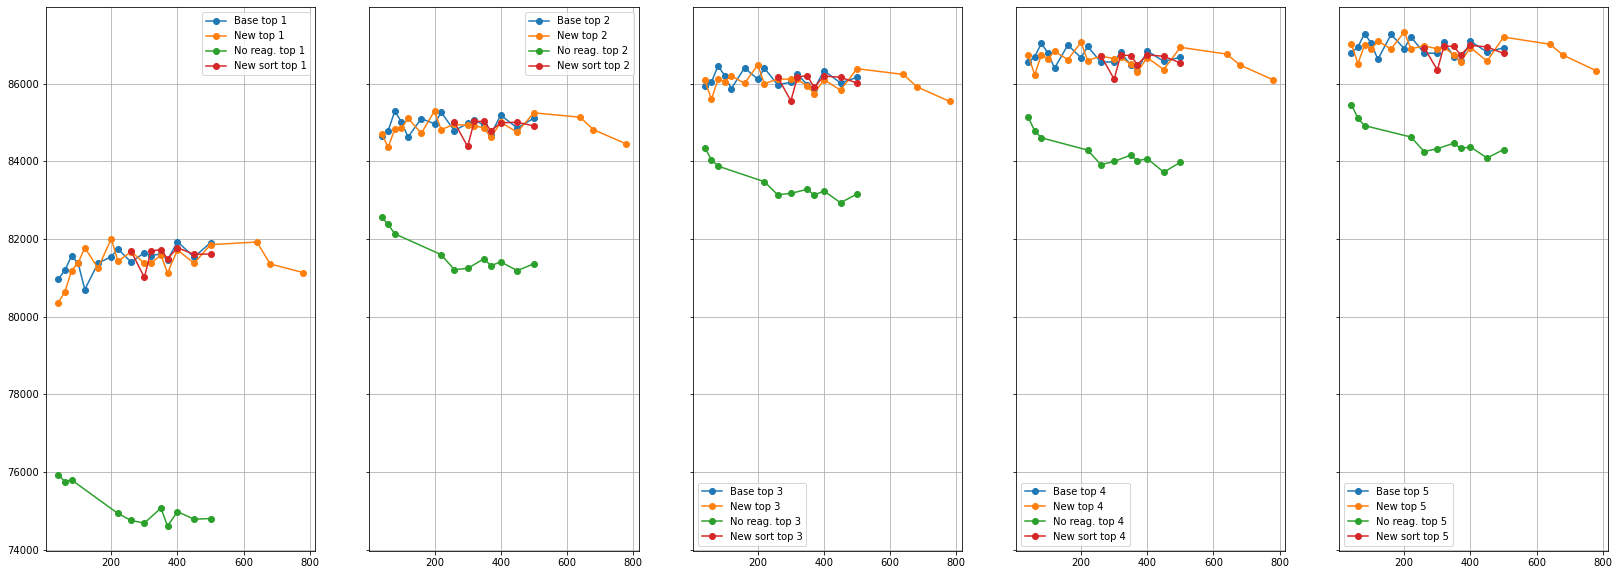

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(28, 10))
_base = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "base"]
_new = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "new"]
_no_rg = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "no_rg"]
_new_sort = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "new_sort"]
for i in range(5):
    plt.sca(ax[i])
    plt.plot(_base.Step, _base[f"top_{i + 1}_exact"], '-o', label=f'Base top {i + 1}')
    plt.plot(_new.Step, _new[f"top_{i + 1}_exact"], '-o', label=f'New top {i + 1}')
    plt.plot(_no_rg.Step, _no_rg[f"top_{i + 1}_exact"], '-o', label=f'No reag. top {i + 1}')
    plt.plot(_new_sort.Step, _new_sort[f"top_{i + 1}_exact"], '-o', label=f'New sort top {i + 1}')
    plt.legend()
    plt.grid()
plt.subplots_adjust()
plt.show()

In [53]:
prod_pred_acc_df

,Model,top_1_exact,top_2_exact,top_3_exact,top_4_exact,top_5_exact,Step,Model_Name
0,mit_sep_40k,80976,84653,85949,86549,86791,40,base
1,mit_sep_40k_repl,80366,84700,86084,86742,87021,40,new
2,mit_sep_40k_no_rg,75938,82563,84350,85138,85462,40,no_rg
3,mit_sep_60k,81196,84790,86041,86690,86951,60,base
4,mit_sep_60k_repl,80641,84368,85598,86226,86514,60,new
5,mit_sep_60k_no_rg,75755,82375,84040,84787,85108,60,no_rg
6,mit_sep_80k,81570,85292,86460,87035,87283,80,base
7,mit_sep_80k_repl,81190,84832,86116,86737,86997,80,new
8,mit_sep_80k_no_rg,75801,82134,83877,84606,84919,80,no_rg
9,mit_sep_100k,81375,85013,86206,86789,87044,100,base


In [54]:
81855 / len(test["Product"])

0.8462301894984958

In [55]:
for i in range(5):
    display(prod_pred_acc_df[["Model", f"top_{i + 1}_exact"]].sort_values([f"top_{i + 1}_exact"], ascending=False).head())

,Model,top_1_exact
16,mit_sep_200k_repl,82012
39,mit_sep_400k,81933
51,mit_sep_640k_repl,81924
47,mit_sep_500k,81908
48,mit_sep_500k_repl,81855


,Model,top_2_exact
16,mit_sep_200k_repl,85296
6,mit_sep_80k,85292
17,mit_sep_220k,85264
48,mit_sep_500k_repl,85248
39,mit_sep_400k,85190


,Model,top_3_exact
16,mit_sep_200k_repl,86483
6,mit_sep_80k,86460
13,mit_sep_160k,86404
17,mit_sep_220k,86397
48,mit_sep_500k_repl,86384


,Model,top_4_exact
16,mit_sep_200k_repl,87066
6,mit_sep_80k,87035
13,mit_sep_160k,86994
17,mit_sep_220k,86956
48,mit_sep_500k_repl,86934


,Model,top_5_exact
16,mit_sep_200k_repl,87331
6,mit_sep_80k,87283
13,mit_sep_160k,87266
17,mit_sep_220k,87204
48,mit_sep_500k_repl,87198


### Mixed setting

In [56]:
precursors_mixed = (test["Reactants"] + '.' + test["Reagents"]).str.strip('.')

In [57]:
precursors_mixed

0                      OC1CN(Cc2ccccc2)CC1O.[H][H].[Pd].CO
1        c1ccc(CN2CCC3(CC2)Cc2ccccc2O3)cc1.[H][H].CC(C)...
2        OC1C2COCC1CN(Cc1ccccc1)C2.[Pd+2].[H][H].[OH-]....
3                       OC1CCN(Cc2ccccc2)C1.[H][H].[Pd].CO
4        Cc1ccc(O)c(Cn2c(NC3CCN(Cc4ccccc4)CC3)nc3ccc(CO...
                               ...                        
96724    CS(=O)(=O)N1CC2CC(OCc3ccccc3)CC2C1.CC(=O)O.[Pd...
96725    C=C(C)C1CCC2(C(=O)NCCN)CCC3(C)C(CCC4C5(C)CCC(O...
96726    CC(=O)OC1CCC2(C)C(CCC3(C)C2CC=C2C4C(C)C(C)CCC4...
96727    COC12C=CC3(CC1C(C)(O)C(C)(C)C)C1Cc4ccc(OCc5ccc...
96728    CC1(C)CCC2(C(=O)NCCNC(=O)c3ccc(OCc4ccccc4)cc3)...
Length: 96729, dtype: object

In [58]:
precursors_mixed.nunique(), precursors_mixed.shape

(96659, (96729,))

In [59]:
MODELS_MIXED = {
    "mit_mix_40k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_40000.pt",
    "mit_mix_40k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_40000.pt",
    "mit_mix_60k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_60000.pt",
    "mit_mix_60k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_60000.pt",
    "mit_mix_80k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_80000.pt",
    "mit_mix_80k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_80000.pt",
    "mit_mix_100k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_100000.pt",
    "mit_mix_100k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_100000.pt",
    "mit_mix_120k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_120000.pt",
    "mit_mix_120k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_120000.pt",
    "mit_mix_140k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_140000.pt",
    "mit_mix_140k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_140000.pt",
    "mit_mix_160k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_160000.pt",
    "mit_mix_160k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_160000.pt",
    "mit_mix_180k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_180000.pt",
    "mit_mix_180k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_180000.pt",
    "mit_mix_200k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_200000.pt",
    "mit_mix_200k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_200000.pt",
    "mit_mix_220k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_220000.pt",
    "mit_mix_220k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_220000.pt",
    "mit_mix_250k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_250000.pt",
    "mit_mix_250k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_250000.pt",
    "mit_mix_300k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_300000.pt",
    "mit_mix_300k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_300000.pt",
    "mit_mix_320k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_320000.pt",
    "mit_mix_320k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_320000.pt",
    "mit_mix_350k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_350000.pt",
    "mit_mix_350k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_350000.pt",
    "mit_mix_370k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_370000.pt",
    "mit_mix_370k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_370000.pt",
    "mit_mix_400k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_400000.pt",
    "mit_mix_400k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_400000.pt",
    "mit_mix_450k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_450000.pt",
    "mit_mix_450k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_450000.pt",
    "mit_mix_500k": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_500000.pt",
    "mit_mix_500k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_500000.pt",

    "mit_mix_680k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_680000.pt",
    "mit_mix_700k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_700000.pt",
    "mit_mix_760k_repl": "/home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_760000.pt"
}


In [60]:
product_predictors_mixed = {}
for name, model in MODELS_MIXED.items():
    product_predictors_mixed[name] = MTProductPredictor(
        model_path=model,
        tokenized_path=f"../data/test/src_{name}.txt",
        output_path=f"../experiments/results/test_reaxys_{name}.txt",
        beam_size=5,
        n_best=5,
        gpu=0
    ) 

In [61]:
product_predictors_mixed

{'mit_mix_40k': <src.prediction.MTProductPredictor at 0x7f283e230c50>,
 'mit_mix_40k_repl': <src.prediction.MTProductPredictor at 0x7f283e230128>,
 'mit_mix_60k': <src.prediction.MTProductPredictor at 0x7f283e230f60>,
 'mit_mix_60k_repl': <src.prediction.MTProductPredictor at 0x7f283e230c18>,
 'mit_mix_80k': <src.prediction.MTProductPredictor at 0x7f283e230320>,
 'mit_mix_80k_repl': <src.prediction.MTProductPredictor at 0x7f283e230ac8>,
 'mit_mix_100k': <src.prediction.MTProductPredictor at 0x7f283e2307b8>,
 'mit_mix_100k_repl': <src.prediction.MTProductPredictor at 0x7f283e2304a8>,
 'mit_mix_120k': <src.prediction.MTProductPredictor at 0x7f283e230208>,
 'mit_mix_120k_repl': <src.prediction.MTProductPredictor at 0x7f283e230eb8>,
 'mit_mix_140k': <src.prediction.MTProductPredictor at 0x7f283e230fd0>,
 'mit_mix_140k_repl': <src.prediction.MTProductPredictor at 0x7f283e230b00>,
 'mit_mix_160k': <src.prediction.MTProductPredictor at 0x7f283e230630>,
 'mit_mix_160k_repl': <src.prediction.MT

In [167]:
%%time
# No need to execute is twice if the predictions are already stored on the disk
for k in product_predictors_mixed:
    if step_num(k) == 40 or step_num(k) > 500:
        product_predictors_mixed[k].predict(precursors_mixed)

Running the command:
python3 /home/mandronov/work/reagents/translate.py -model /home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_model_1gpu_step_40000.pt -src ../data/test/src_mit_mix_40k.txt -output ../experiments/results/test_reaxys_mit_mix_40k.txt -batch_size 64 -max_length 200 -beam_size 5 -n_best 5 -log_probs -replace_unk -fast -gpu 0
Running the command:
python3 /home/mandronov/work/reagents/translate.py -model /home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_40000.pt -src ../data/test/src_mit_mix_40k_repl.txt -output ../experiments/results/test_reaxys_mit_mix_40k_repl.txt -batch_size 64 -max_length 200 -beam_size 5 -n_best 5 -log_probs -replace_unk -fast -gpu 0
Running the command:
python3 /home/mandronov/work/reagents/translate.py -model /home/mandronov/work/reagents/experiments/trained_models/MIT_mixed_reags_top1_and_rdkit_model_1gpu_step_680000.pt -src ../data/test/src_mit_mix_680k_repl.txt -output ../exp

In [62]:
for k in product_predictors_mixed:
    product_predictors_mixed[k].load_predictions()

In [63]:
for k in product_predictors_mixed:
    for c in product_predictors_mixed[k].predictions.columns:
        product_predictors_mixed[k].predictions[c] = product_predictors_mixed[k].predictions[c].progress_apply(lambda smi: ut.canonicalize_smiles(max(smi.split('.'), key=len)))

100%|██████████| 96729/96729 [00:19<00:00, 4840.45it/s]


In [64]:
prod_pred_acc_mixed = {
    "Model": [], 
    "top_1_exact": [], 
    "top_2_exact": [], 
    "top_3_exact": [], 
    "top_4_exact": [], 
    "top_5_exact": []
}

In [65]:
for k in product_predictors_mixed:
    prod_pred_acc_mixed["Model"].append(k)
    prod_topn_exact_match_acc_mixed = pd.concat(
        (
            test["Product"], 
            product_predictors_mixed[k].predictions
        )
        , axis=1).apply(lambda x: match_accuracy(x, 'exact'), axis=1)

    prod_topn_exact_match_acc_mixed = pd.DataFrame(prod_topn_exact_match_acc_mixed.to_list())
    prod_topn_exact_match_acc_mixed.columns = [f"top_{i + 1}_exact" for i in range(5)]

    for c in prod_topn_exact_match_acc_mixed.columns:
        prod_pred_acc_mixed[c].append(prod_topn_exact_match_acc_mixed[c].sum())

In [66]:
prod_pred_acc_mixed_df = pd.DataFrame.from_dict(prod_pred_acc_mixed)

In [67]:
prod_pred_acc_mixed_df["Step"] = prod_pred_acc_mixed_df["Model"].apply(lambda x: x.strip("_repl").split("_")[-1].strip("k")).astype(int)
prod_pred_acc_mixed_df["Model_Name"] = prod_pred_acc_mixed_df["Model"].apply(lambda x: "new" if x.endswith("repl") else "base")
prod_pred_acc_mixed_df

,Model,top_1_exact,top_2_exact,top_3_exact,top_4_exact,top_5_exact,Step,Model_Name
0,mit_mix_40k,79340,83495,84955,85636,85950,40,base
1,mit_mix_40k_repl,78676,82858,84344,85072,85429,40,new
2,mit_mix_60k,79087,83047,84504,85212,85516,60,base
3,mit_mix_60k_repl,78965,83111,84573,85267,85556,60,new
4,mit_mix_80k,79428,83146,84540,85245,85554,80,base
5,mit_mix_80k_repl,79189,83550,84938,85598,85905,80,new
6,mit_mix_100k,79046,82855,84281,84972,85283,100,base
7,mit_mix_100k_repl,78909,82976,84292,84982,85314,100,new
8,mit_mix_120k,78776,82654,84051,84747,85065,120,base
9,mit_mix_120k_repl,78899,82706,84042,84769,85089,120,new


In [68]:
prod_pred_acc_mixed_df.loc[[34, 35]]["top_1_exact"] / test.shape[0]

34    0.820209
35    0.830268
Name: top_1_exact, dtype: float64

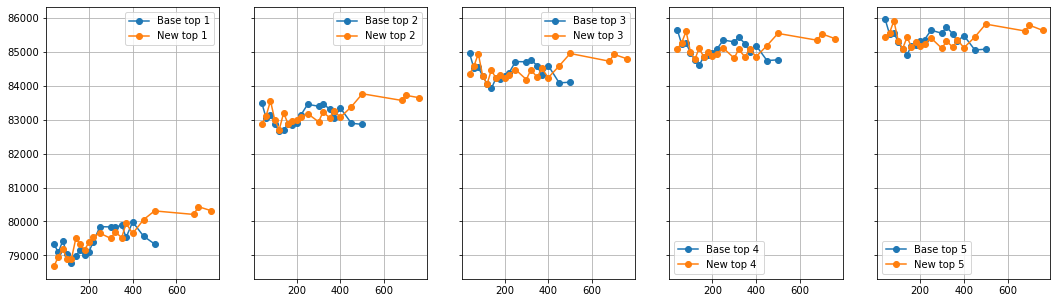

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18, 5))
_base = prod_pred_acc_mixed_df[prod_pred_acc_mixed_df["Model_Name"] == "base"]
_new = prod_pred_acc_mixed_df[prod_pred_acc_mixed_df["Model_Name"] == "new"]
for i in range(5):
    plt.sca(ax[i])
    plt.plot(_base.Step, _base[f"top_{i + 1}_exact"], '-o', label=f'Base top {i + 1}')
    plt.plot(_new.Step, _new[f"top_{i + 1}_exact"], '-o', label=f'New top {i + 1}')
    plt.legend()
    plt.grid()
plt.subplots_adjust()
plt.show()

In [70]:
for i in range(5):
    display(prod_pred_acc_mixed_df[["Model", f"top_{i + 1}_exact"]].sort_values([f"top_{i + 1}_exact"], ascending=False).set_index("Model").head() / test.shape[0])

,top_1_exact
Model,
mit_mix_700k_repl,0.831571
mit_mix_760k_repl,0.830309
mit_mix_500k_repl,0.830268
mit_mix_680k_repl,0.829193
mit_mix_450k_repl,0.827611


,top_2_exact
Model,
mit_mix_500k_repl,0.865914
mit_mix_700k_repl,0.865438
mit_mix_760k_repl,0.864715
mit_mix_680k_repl,0.863898
mit_mix_80k_repl,0.863753


,top_3_exact
Model,
mit_mix_40k,0.878278
mit_mix_500k_repl,0.878175
mit_mix_80k_repl,0.878103
mit_mix_700k_repl,0.877927
mit_mix_760k_repl,0.876562


,top_4_exact
Model,
mit_mix_40k,0.885319
mit_mix_80k_repl,0.884926
mit_mix_500k_repl,0.884285
mit_mix_700k_repl,0.884161
mit_mix_320k,0.883137


,top_5_exact
Model,
mit_mix_40k,0.888565
mit_mix_80k_repl,0.888100
mit_mix_500k_repl,0.887118
mit_mix_700k_repl,0.886787
mit_mix_320k,0.886311


### All together

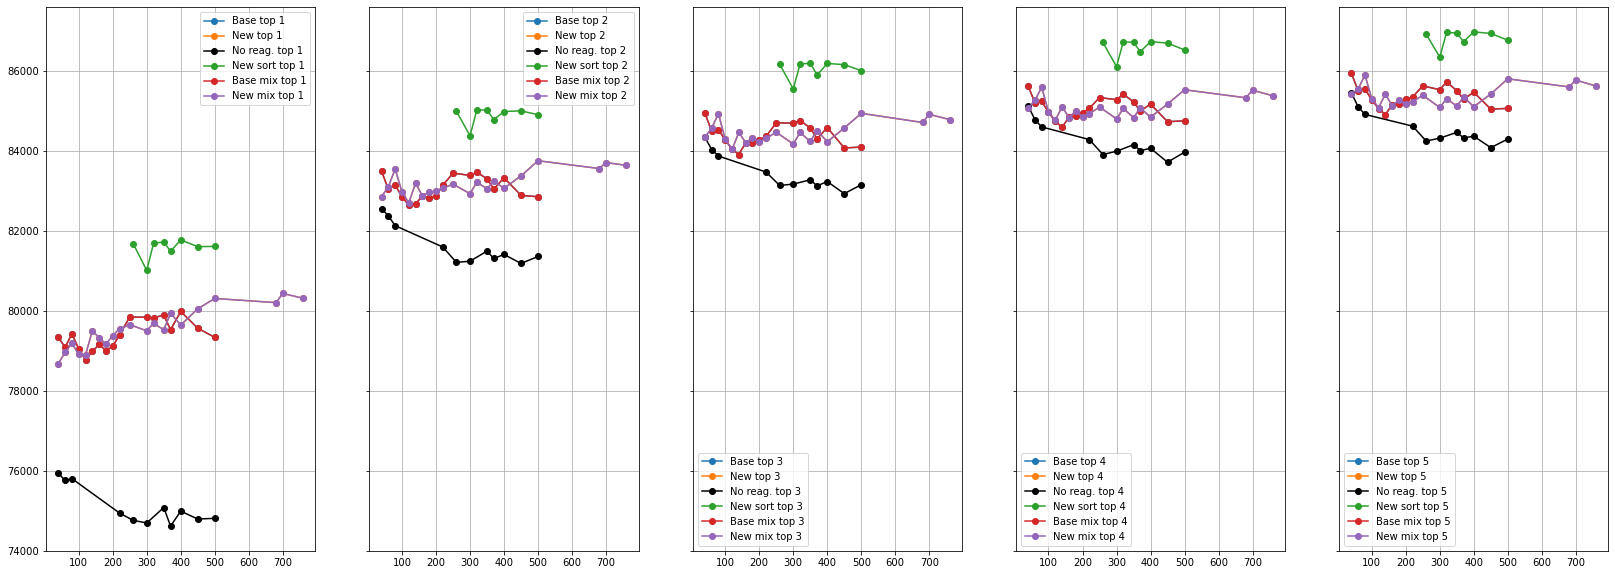

In [177]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(28, 10))
_base_sep = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "base"]
_new_sep = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "new"]
_no_rg = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "no_rg"]
_new_sort_sep = prod_pred_acc_df[prod_pred_acc_df["Model_Name"] == "new_sort"]
_base_mix = prod_pred_acc_mixed_df[prod_pred_acc_mixed_df["Model_Name"] == "base"]
_new_mix = prod_pred_acc_mixed_df[prod_pred_acc_mixed_df["Model_Name"] == "new"]
for i in range(5):
    plt.sca(ax[i])
    plt.plot(_base.Step, _base[f"top_{i + 1}_exact"], '-o', label=f'Base top {i + 1}')
    plt.plot(_new.Step, _new[f"top_{i + 1}_exact"], '-o', label=f'New top {i + 1}')
    plt.plot(_no_rg.Step, _no_rg[f"top_{i + 1}_exact"], '-o', label=f'No reag. top {i + 1}', c='k')
    plt.plot(_new_sort.Step, _new_sort[f"top_{i + 1}_exact"], '-o', label=f'New sort top {i + 1}')
    plt.plot(_base_mix.Step, _base_mix[f"top_{i + 1}_exact"], '-o', label=f'Base mix top {i + 1}')
    plt.plot(_new_mix.Step, _new_mix[f"top_{i + 1}_exact"], '-o', label=f'New mix top {i + 1}')
    plt.legend()
    plt.grid()
plt.subplots_adjust()
plt.show()

In [ ]:
_no_rg

In [ ]:
74808 / len(test)

### Statistical tests

In [84]:
from scipy import stats
def mcnemar_test(n_old_best, n_new_best, alpha=0.05):
    mcnemar = (np.abs(n_old_best - n_new_best) - 1)**2 / (n_old_best + n_new_best)
    print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
    p_value = 1 - stats.chi2.cdf(mcnemar, 1)
    conclusion = "Failed to reject the null hypothesis."
    if p_value <= alpha:
        conclusion = "Null Hypothesis is rejected."

    print("McNemar's statistic is:", round(mcnemar, 2), " and p value is:", p_value)
    print(conclusion)

In [86]:
old_model = "mit_mix_500k"
new_model = "mit_mix_500k_repl"

new = pd.concat(
        (
            test["Product"], 
            product_predictors_mixed[new_model].predictions
        ), axis=1).apply(lambda x: match_accuracy(x[:2], 'exact'), axis=1)
new = pd.DataFrame(new.to_list())
new.columns = ["new"]

old = pd.concat(
        (
            test["Product"], 
            product_predictors_mixed[old_model].predictions
        ), axis=1).apply(lambda x: match_accuracy(x[:2], 'exact'), axis=1)
old = pd.DataFrame(old.to_list())
old.columns = ["old"]

pd.crosstab(old["old"], new["new"])

new,0,1
old,,
0,12768,4623
1,3650,75688


In [141]:
mcnemar_test(1215, 1347)

Approach 1: The p-value approach to hypothesis testing in the decision rule
McNemar's statistic is: 6.7  and p value is: 0.009650582375742678
Null Hypothesis is rejected.


# USPTO

In [88]:
with open("../data/tokenized/MIT_mixed_reags_top1_and_rdkit/tgt-test.txt") as f:
    uspto_tgt = [i.strip().replace(" ", "") for i in f.readlines()]

In [89]:
uspto_tgt[:5]

['N#Cc1ccsc1Nc1cc(F)c(F)cc1[N+](=O)[O-]',
 'COC(=O)Cc1cn(C)c2cc(OCC(C)c3cn(-c4ccc(C(F)(F)F)cc4)nc3C)ccc12',
 'O=c1ccc2ncc(F)c3c2n1CC3CN1CCC(NCc2cc3c(cn2)OCS3)C(O)C1',
 'C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(=C(C)c3cc(-c4ccccc4)sc3C)C2=O)cc1',
 'OCc1cncc(Cl)c1COC1CCCCO1']

In [265]:
p1 = 

In [90]:
with open(p1) as f:
    # preds_uspto_mixed_new = [i.strip().replace(" ", "") for i in f.readlines()]
    preds_uspto_mixed_new = [ut.canonicalize_smiles(max(i.strip().replace(" ", "").split('.'), key=len)) for i in f.readlines()]

NameError: name 'p1' is not defined

In [291]:
(np.array(preds_uspto_mixed_new[::5]) == np.array(uspto_tgt)).mean()

0.879325

In [282]:
[i for i in range(0, 21)][::5]

[0, 5, 10, 15, 20]

In [105]:
from rdkit import Chem
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    else:
        return ''


def get_rank(row, base, max_rank):
    for i in range(1, max_rank + 1):
        if row['target'] == row['{}{}'.format(base, i)]:
            return i
    return 0

opt_targets = "../data/tokenized/MIT_mixed/tgt-test.txt"
opt_beam_size = 5
opt_predictions = "../experiments/results/predictions_MIT_mixed_model_1gpu_step_500000.pt_on_MIT_mixed_test.txt"


with open(opt_targets, 'r') as f:
    targets = [''.join(line.strip().split(' ')) for line in f.readlines()]

predictions = [[] for i in range(opt_beam_size)]

test_df = pd.DataFrame(targets)
test_df.columns = ['target']
total = len(test_df)

with open(opt_predictions, 'r') as f:
    for i, line in enumerate(f.readlines()):
        predictions[i % opt_beam_size].append(''.join(line.strip().split(' ')))

for i, preds in enumerate(predictions):
    test_df['prediction_{}'.format(i + 1)] = preds
    test_df['canonical_prediction_{}'.format(i + 1)] = test_df['prediction_{}'.format(i + 1)].apply(
        lambda x: canonicalize_smiles(x))

test_df['rank'] = test_df.apply(lambda row: get_rank(row, 'canonical_prediction_', opt_beam_size), axis=1)

correct = 0

for i in range(1, opt_beam_size + 1):
    correct += (test_df['rank'] == i).sum()
    invalid_smiles = (test_df['canonical_prediction_{}'.format(i)] == '').sum()
    if False: # opt.invalid_smiles:
        print('Top-{}: {:.3f}% || Invalid SMILES {:.2f}%'.format(i, correct / total * 100,
                                                                     invalid_smiles / total * 100))
    else:
        print('Top-{}: {:.3f}%'.format(i, correct / total * 100))

Top-1: 87.730%
Top-2: 91.407%
Top-3: 92.397%
Top-4: 92.900%
Top-5: 93.165%


In [104]:
test_df_mixed_new = test_df.copy()

In [106]:
test_df_mixed_old = test_df.copy()

In [110]:
((test_df_mixed_old["rank"] == 1) & (test_df_mixed_new["rank"] == 1)).sum()

33877

In [101]:
(34616 + 1068) / len(test_df)

0.8921